# 코스워크 설명
* 학교 및 학과: University of Nottingham (UK), MSc Business Analytics
https://www.nottingham.ac.uk/pgstudy/course/taught/business-analytics-msc

* 강의명: Machine Learning and Predictive Analytics
* 년도: 2020
* 사용 언어:Python, PostgreSQL
* 주제: 이탈률 예측 분석

### **문제 탐색 및 정의**
매주 같은 시간에 예측을 실시하는 churn prediction 모델을 만든다. 
1. 주어진 그래프 및 차트에서churn의 정보를 해석하고, churn을 정의한다.
2. Temporal data를 활용하여 churn 예측 모델을 구축한다. 
3. Churn vs Non-churn에 대한 차이점을 바탕으로 인사이트를 제공한다. 

2년 동안 수집된 4개의 상점 데이터가 주어진다. 데이터는 5개의 SQL 테이블로 이루어져 있으며 테이블 명은 아래와 같다.
* Customers (id, 생일년도, 이름)
* Products (code and details of product, department, category and sub category)
* Receipt lines (영수증 id, product code, 가격 및 수량)
* Receipts (영수증 id, 구매시간, id, 상점 번호, 계산대)
* Stores (가게 정보들)



### **데이터 분석 과정**
##### 요약
이탈률의 기준으 33일로 정하고, tumbling window size 및 output window size를 33으로 정했다. Processing를 거진 후 XGboost algorithm를 사용하여 51.4%의 이탈률를 예측했다.  

##### Churn정의
주어진 그래프를 해석하고 churn를 정의한다. Churn definition as 33 days can be construed as 59.88 per cent of customers visit less than this in median and Foodcorp can expect to target 19.03 per cent of active customers with a perfect classifier.

##### Churn 예측 모델
선택한 특징들을 설명하고, 예측 모델을 만든다.
* Processing: balancing an output feature in the raining dataset using SMOTE and standardization of each traditional numerical variables and temporal variables.  
* Feature importance & selection: RFECV (Recursive feature elimination cross-validation)와 RFE를 사용했다. Total values, average between 그리고 total quantity를 비롯해 33을 기준으로 총 지출을 합한 11개의 temporal variable를 바탕으로 REF를 실시했다. 
* Randomized search CV를 사용해 XGBoost classifier의 하이퍼 파라미터를 찾고 예측을 실행했다.


##### 인사이트 리포트
Churner과 non-churner를 비교 분석하고, 마케팅 전략을 제시한다. 두 그룹의 가장 큰 차이는 총 구매 지출과 수량이었으며 특정 기간의 총 구매 지출이었다. 이를 바탕으로  Churner그룹은 할인쿠폰과 업셀링과 같은 bounce back marketing 전략을, Non-churner그룹은 특별한 제품 리워드와 같은 loyalty program 마케팅 전략을 수립했다. 

# Report
https://github.com/Chan-Young/Coursework/blob/main/Classification_Churn%20Prediciton.pdf

# A. Package preparation

In [1]:
# General
import psycopg2
from matplotlib import style
plt.style.use('ggplot')
mpl.rcParams['axes.unicode_minus'] = False
import warnings
warnings.filterwarnings(action='ignore') 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.legend_handler import HandlerLine2D
from collections import Counter
from numpy import where
from texttable import Texttable

# Preprocessing
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import KMeansSMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTENC
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Modelling
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from yellowbrick.classifier import ROCAUC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

# Feature Importance
from sklearn.feature_selection import GenericUnivariateSelect
from sklearn.feature_selection import mutual_info_classif
from xgboost import plot_importance
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.feature_selection import RFE
from yellowbrick.model_selection import RFECV
from sklearn.inspection import plot_partial_dependence

# B. Data preparation

### 1. Importing data

###### 1) Account

In [2]:
user = 'lixcl68'
db_ip = '10.158.72.132'
pw = 'Lcyg1a1n1g1!'

###### 2) Importing data from database

In [3]:
def get_dataset_value( reference_day=576, tumbling_window_size = 33, output_window_size = 33, num_periods = 11, window_agg_fun = 'SUM', output_agg_fun = 'SUM' ):
    sql_top = """
    SELECT customer_id, 
           sum(values) as total_values, 
           sum(quantity) as total_quantity, 
           sum(between) / count(between) as avg_between, 
           last_purchased,
    %(ref_date)s::INT AS ref_day,
    {0}(CASE WHEN day > %(ref_date)s::INT AND day <= %(ref_date)s::INT + %(ows)s::INT THEN values ELSE 0 END) as output_feature,
    {1}(CASE WHEN day > %(ref_date)s::INT -%(ws)s::INT AND day <= %(ref_date)s::INT THEN values ELSE 0 END ) as f1,
    """.format(output_agg_fun, window_agg_fun)
    
    sql = sql_top
    
    for i in range(1,num_periods):
           sql += "{2}(CASE WHEN day > %(ref_date)s::INT -%(ws)s::INT*({0}+1) AND day <= %(ref_date)s::INT-%(ws)s::INT*({0}) THEN values ELSE 0 END ) as f{1},\n".format(i, i+1, window_agg_fun)
    
    sql_bottom = """
    FROM final
    WHERE customer_id in (
                    SELECT customer_id
                    FROM final
                    WHERE day > %(ref_date)s::INT - %(ows)s::INT  and day <= %(ref_date)s::INT
                        )
    GROUP BY customer_id, last_purchased
    """
    sql = sql[:-2] + sql_bottom
    
    with psycopg2.connect("host='{}' dbname='nlab' user='{}' password='{}'".format(db_ip, user, pw)) as conn:
        df = pd.read_sql(sql, conn, params = {'ref_date':reference_day, 'ws':tumbling_window_size, 'ows':output_window_size})
    
    return df.drop(columns = ['ref_day','last_purchased','customer_id','output_feature'
                             ], inplace = False), df.output_feature

### 2. Final function of comparing list of models by f1 score 
#####     (get_f1 function, including preprocessing such as SMOTE and standardization)

In [4]:
def get_f1(model, total_holdout_sets, now, ws, ows):
    scores = []
    
    # for each holdout set, compute f1 score
    for i in range(total_holdout_sets):
        valid = get_dataset_value(now-2*ows, ws, ows)
        train = get_dataset_value(now-3*ows, ws, ows)

         # output feature changes to binary, 1: non- churn, 0: churn
        valid[1][valid[1]>0] = 1 # non-chrun
        train[1][train[1]>0] = 1 # non-chrun
        
        # Balancing unbalanced output feature in train data set using SMOTE
        smote = SMOTE(random_state=42)
        X_train, y_train = smote.fit_resample(train[0], train[1])
        
        X_train = pd.DataFrame(X_train,
                      columns=['total_values','total_quantity','avg_between',
                              'f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11'])
        y_train = pd.DataFrame(y_train)
        
        # standardizing Temporal data in train set
        train_X = pd.DataFrame()

        for i in X_train.iloc[:,3:14].values:
            a = i - X_train.iloc[:,3:14].values.sum()
            b = a / np.std(X_train.iloc[:,3:14].values)
    
            new_row = pd.DataFrame( [[b]] )
            train_X = train_X.append(new_row, ignore_index = True)

        train_X.columns = ['f']
        train_X = pd.DataFrame(train_X.f.tolist(), 
                            columns=['f1','f2','f3','f4','f5','f6','f7','f8',
                                         'f9','f10','f11'])

        # standardizing traditional data in train set
        # Step 1: log1p
        train_X2 = X_train.drop(columns=['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11'])
        train_X2_log = np.log1p(train_X2)
        # Step 2: StandardScaler
        scaler = StandardScaler()
        train_X2_scaled = scaler.fit_transform(train_X2_log)

        # transform into a dataframe
        train_X2_scaled = pd.DataFrame(train_X2_scaled, index=train_X2_log.index, 
                             columns=train_X2_log.columns)
        final_train = pd.concat([train_X2_scaled, train_X], axis=1)
        final_train = round(final_train,2)
        
        # standardizing Temporal data in validation set
        valid_X = pd.DataFrame()

        for i in valid[0].iloc[:,3:14].values:
            a = i - valid[0].iloc[:,3:14].values.sum()
            b = a / np.std(valid[0].iloc[:,3:14].values)
    
            new_row = pd.DataFrame( [[b]] )
            valid_X = valid_X.append(new_row, ignore_index = True)

        valid_X.columns = ['f']
        valid_X = pd.DataFrame(valid_X.f.tolist(), 
                            columns=['f1','f2','f3','f4','f5','f6','f7','f8',
                                         'f9','f10','f11'])

        # standardizing traditional data in validation set
        # Step 1: log1p
        valid_X2 = valid[0].drop(columns=['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11'])
        valid_X2_log = np.log1p(valid_X2)
        # Step 2: StandardScaler
        scaler = StandardScaler()
        valid_X2_scaled = scaler.fit_transform(valid_X2_log)

        # transform into a dataframe
        valid_X2_scaled = pd.DataFrame(valid_X2_scaled, index=valid_X2_log.index, 
                             columns=valid_X2_log.columns)
        # Merge into final
        final_valid = pd.concat([valid_X2_scaled, valid_X], axis=1)
        final_valid = round(final_valid,2)
        
        # prediction using f1_score
        model.fit(final_train, y_train)
        preds = model.predict(final_valid)
        s = f1_score(valid[1], preds)
        s = round(s,3)
        scores.append(s)  
        now = now - ows
        
    return round(np.mean(scores),3)

### 3. List of models 

In [5]:
list_of_models = []

m1 = LogisticRegression( solver = 'liblinear', random_state=42)
m2 = KNeighborsClassifier()
m3 = LinearSVC(C=1, loss='hinge',random_state=42)
m4 = LinearSVC(random_state=42)
m5 = SVC(kernel='rbf', gamma=5, C=1,random_state=42)
m6 = SVC(random_state=42)
m7 = GaussianProcessClassifier(1.0 * RBF(1.0),random_state=42)
m8 = GaussianProcessClassifier(random_state=42)

m9 = DecisionTreeClassifier(max_depth=5,random_state=42)
m10 = DecisionTreeClassifier(random_state=42)
m11 = RandomForestClassifier(max_depth=5, n_estimators=10, 
                             max_features=1,random_state=42)
m12 = RandomForestClassifier(random_state=42)
m13 = GaussianNB()

m14 = AdaBoostClassifier(n_estimators=100, random_state=42)
m15 = GradientBoostingClassifier(n_estimators=100, random_state=42)
m16 = xgb.XGBClassifier(random_state=42)

list_of_models += [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10,
                   m11, m12, m13,m14,m15,m16]

### 4. Comparing each model's f1 score

In [6]:
ws = 33
ows = 33
now = 609
f1_comparison = pd.DataFrame()

for model in list_of_models:
    scores =  get_f1(model, total_holdout_sets=2,
                     now=now, ws=ws, ows=ows)
    new_row = pd.DataFrame( [[model, scores]] )
    f1_comparison = f1_comparison.append(new_row, ignore_index = True)
    print(model, 'completed')
        
f1_comparison = f1_comparison.rename(
   columns={0:'model', 1:'f1_score'})

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False) completed
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform') completed
LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
          penalty='l2', random_state=42, tol=0.0001, verbose=0) completed
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0) completed
SVC(C=1, 

In [7]:
f1_comparison

,model,f1_score
0,"LogisticRegression(C=1.0, class_weight=None, d...",0.800
1,"KNeighborsClassifier(algorithm='auto', leaf_si...",0.713
2,"LinearSVC(C=1, class_weight=None, dual=True, f...",0.352
3,"LinearSVC(C=1.0, class_weight=None, dual=True,...",0.352
4,"SVC(C=1, break_ties=False, cache_size=200, cla...",0.713
5,"SVC(C=1.0, break_ties=False, cache_size=200, c...",0.713
6,"GaussianProcessClassifier(copy_X_train=True, k...",0.000
7,"GaussianProcessClassifier(copy_X_train=True, k...",0.000
8,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",0.691
9,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",0.657


In [233]:
# Basemodel predcition
valid = get_dataset_value(now-2*ows, ws, ows)
valid[1][valid[1]>0] = 1 # non-chrun
valid[0].loc[ (valid[0].f1 > 0), 'f1' ] = 1 # non-churn
b = f1_score(valid[1], valid[0].f1)
print('Baseline f1 score:{}'.format(round(b,3)))

Baseline f1 score:0.723


### 5. Details of preprocessing data (get_f1 function)

###### 1) Data preparation for SMOTE

In [192]:
now = 609
ows = 33
ws = 33

valid = get_dataset_value(now-2*ows, ws, ows)
train1 = get_dataset_value(now-3*ows, ws, ows)

valid[1][valid[1]>0]=1
train1[1][train1[1]>0]=1

###### 2) Finding the best method for balancing unbalanced train dataset

In [9]:
# 1. SMOTE
print('Before(train[1]):     ', Counter(train1[1]))
k_values = [1, 2, 3, 4, 5, 6, 7]
for k in k_values:
    m2 = KNeighborsClassifier()
    oversample = SMOTE(k_neighbors=k, random_state=42)
    train_X, train_y = oversample.fit_resample(train1[0], train1[1])
    m2.fit(train_X, train_y)
    preds = m2.predict(valid[0])
    s = f1_score(valid[1], preds)
    print('> k=%d,f1_score: %s' % (k, round(s,3)))
print('After SMOTE(train[1]):', Counter(train_y))

Before(train[1]):      Counter({1.0: 460, 0.0: 388})
> k=1,f1_score: 0.811
> k=2,f1_score: 0.791
> k=3,f1_score: 0.796
> k=4,f1_score: 0.811
> k=5,f1_score: 0.807
> k=6,f1_score: 0.8
> k=7,f1_score: 0.804
After SMOTE(train[1]): Counter({1.0: 460, 0.0: 460})


In [10]:
# 2. Borderline SMOTE
print('Before(train1[1]):               ', Counter(train1[1]))
k_values = [1, 2, 3, 4, 5, 6, 7]
for k in k_values:
    m2 = KNeighborsClassifier()
    oversample = BorderlineSMOTE(k_neighbors=k, random_state=42)
    train2_X, train2_y = oversample.fit_resample(train1[0], train1[1])
    m2.fit(train2_X, train2_y)
    preds = m2.predict(valid[0])
    s = f1_score(valid[1], preds)
    print('> k=%d,f1_score: %s' % (k, round(s,3)))
print('After Borderline SMOTE(train[1]):', Counter(train2_y))

Before(train1[1]):                Counter({1.0: 460, 0.0: 388})
> k=1,f1_score: 0.786
> k=2,f1_score: 0.788
> k=3,f1_score: 0.786
> k=4,f1_score: 0.787
> k=5,f1_score: 0.789
> k=6,f1_score: 0.791
> k=7,f1_score: 0.784
After Borderline SMOTE(train[1]): Counter({1.0: 460, 0.0: 460})


In [11]:
# 3. SVM SMOTE 
print('Before(train1[1]):       ', Counter(train1[1]))
k_values = [1, 2, 3, 4, 5, 6, 7]
for k in k_values:
    m2 = KNeighborsClassifier()
    oversample = SVMSMOTE(k_neighbors=k, random_state=42)
    train3_X, train3_y = oversample.fit_resample(train1[0], train1[1])
    m2.fit(train3_X, train3_y)
    preds = m2.predict(valid[0])
    s = f1_score(valid[1], preds)
    print('> k=%d,f1_score: %s' % (k, round(s,3)))
print('After SVM SMOTE(train3[1]):', Counter(train3_y))

Before(train1[1]):        Counter({1.0: 460, 0.0: 388})
> k=1,f1_score: 0.793
> k=2,f1_score: 0.8
> k=3,f1_score: 0.799
> k=4,f1_score: 0.796
> k=5,f1_score: 0.793
> k=6,f1_score: 0.792
> k=7,f1_score: 0.786
After SVM SMOTE(train3[1]): Counter({1.0: 460, 0.0: 460})


In [12]:
# 4. ADASYN
print('Before(train1[1]):       ', Counter(train1[1]))
oversample = ADASYN(random_state=42)
train4_X, train4_y = oversample.fit_resample(train1[0], train1[1])
m2 = KNeighborsClassifier()
m2.fit(train4_X, train4_y)
preds = m2.predict(valid[0])
s = f1_score(valid[1], preds)
print('f1 score:', round(s,3))
print('After ADASYN(train3[1]):', Counter(train4_y))

Before(train1[1]):        Counter({1.0: 460, 0.0: 388})
f1 score: 0.789
After ADASYN(train3[1]): Counter({1.0: 460, 0.0: 450})


In [13]:
# 5. Kmeans SMOTE
from imblearn.over_sampling import KMeansSMOTE
print('Before(train1[1]):          ', Counter(train1[1]))
k_values = [1, 2, 3, 4, 5, 6, 7]
for k in k_values:
    m2 = KNeighborsClassifier()
    oversample = KMeansSMOTE(k_neighbors=k, random_state=42)
    train5_X, train5_y = oversample.fit_resample(train1[0], train1[1])
    m2.fit(train5_X, train5_y)
    preds = m2.predict(valid[0])
    s = f1_score(valid[1], preds)
    print('> k=%d,f1_score: %s' % (k, round(s,3)))
print('After Kmeans SMOTE(train[1]):', Counter(train5_y))

Before(train1[1]):           Counter({1.0: 460, 0.0: 388})
> k=1,f1_score: 0.819
> k=2,f1_score: 0.817
> k=3,f1_score: 0.818
> k=4,f1_score: 0.818
> k=5,f1_score: 0.821
> k=6,f1_score: 0.818
> k=7,f1_score: 0.82
After Kmeans SMOTE(train[1]): Counter({1.0: 460, 0.0: 460})


In [14]:
# 6. RandomOverSampler
from imblearn.over_sampling import RandomOverSampler
print('Before(train1[1]):                ', Counter(train1[1]))
m2 = KNeighborsClassifier()
oversample = RandomOverSampler(random_state=42)
train6_X, train6_y = oversample.fit_resample(train1[0], train1[1])
m2.fit(train6_X, train6_y)
preds = m2.predict(valid[0])
s = f1_score(valid[1], preds)
print('f1 score:', round(s,3))
print('After RandomOverSampler(train[1]):', Counter(train6_y))

Before(train1[1]):                 Counter({1.0: 460, 0.0: 388})
f1 score: 0.814
After RandomOverSampler(train[1]): Counter({1.0: 460, 0.0: 460})


In [15]:
# 7. SMOTENC
from imblearn.over_sampling import SMOTENC
print('Before(train1[1]):                ', Counter(train1[1]))
k_values = [1, 2, 3, 4, 5, 6, 7]
for k in k_values:
    m2 = KNeighborsClassifier()
    oversample = SMOTENC(k_neighbors=k, random_state=42, categorical_features=[0,1])
    train7_X, train7_y = oversample.fit_resample(train1[0], train1[1])
    m2.fit(train7_X, train7_y)
    preds = m2.predict(valid[0])
    s = f1_score(valid[1], preds)
    print('> k=%d,f1_score: %s' % (k, round(s,3)))
print('After RandomOverSampler(train[7]):', Counter(train7_y))

Before(train1[1]):                 Counter({1.0: 460, 0.0: 388})
> k=1,f1_score: 0.801
> k=2,f1_score: 0.805
> k=3,f1_score: 0.815
> k=4,f1_score: 0.818
> k=5,f1_score: 0.811
> k=6,f1_score: 0.806
> k=7,f1_score: 0.812
After RandomOverSampler(train[7]): Counter({1.0: 460, 0.0: 460})


In [16]:
# 8. SMOTEENN
from imblearn.combine import SMOTEENN
print('Before(train1[1]):                ', Counter(train1[1]))
m2 = KNeighborsClassifier()
oversample = SMOTEENN(random_state=42)
train8_X, train8_y = oversample.fit_resample(train1[0], train1[1])
m2.fit(train8_X, train8_y)
preds = m2.predict(valid[0])
s = f1_score(valid[1], preds)
print('f1 score:', round(s,3))
print('After RandomOverSampler(train[8]):', Counter(train8_y))

Before(train1[1]):                 Counter({1.0: 460, 0.0: 388})
f1 score: 0.805
After RandomOverSampler(train[8]): Counter({1.0: 275, 0.0: 271})


In [17]:
# 9. SMOTETomek
from imblearn.combine import SMOTETomek
print('Before(train1[1]):                ', Counter(train1[1]))
m2 = KNeighborsClassifier()
oversample = SMOTETomek(random_state=42)
train9_X, train9_y = oversample.fit_resample(train1[0], train1[1])
valid9_X, valid9_y = oversample.fit_resample(valid[0], valid[1])
m2.fit(train9_X, train9_y)
preds = m2.predict(valid[0])
s = f1_score(valid[1], preds)
print('f1 score:', round(s,3))
print('After RandomOverSampler(train[9]):', Counter(train9_y))

Before(train1[1]):                 Counter({1.0: 460, 0.0: 388})
f1 score: 0.811
After RandomOverSampler(train[9]): Counter({1.0: 436, 0.0: 436})


###### 3) Data preparation for standardization

In [193]:
now = 609
ows = 33
ws = 33

valid = get_dataset_value(now-2*ows, ws, ows)
train = get_dataset_value(now-3*ows, ws, ows)

###### 4) Standardization of temporal data in validation set

In [20]:
# valid temporal data standarization
valid_X = pd.DataFrame()

for i in valid[0].iloc[:,3:14].values:
    a = i - valid[0].iloc[:,3:14].values.sum()
    b = a / np.std(valid[0].iloc[:,3:14].values)
    #print(b)
    
    new_row = pd.DataFrame( [[b]] )
    valid_X = valid_X.append(new_row, ignore_index = True)

valid_X.columns = ['f']
valid_X = pd.DataFrame(valid_X.f.tolist(), 
                        columns=['f1','f2','f3','f4','f5','f6','f7','f8',
                                         'f9','f10','f11'])
valid_X.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11
0,-4779.877723,-4779.790736,-4779.790144,-4779.412262,-4779.959227,-4779.847344,-4779.775325,-4779.959227,-4779.959227,-4779.959227,-4779.959227
1,-4779.885133,-4779.959227,-4779.959227,-4779.959227,-4779.959227,-4779.885133,-4779.959227,-4779.926774,-4779.959227,-4779.959227,-4779.959227
2,-4779.815928,-4779.959227,-4779.959227,-4779.959227,-4779.959227,-4779.959227,-4779.959227,-4779.959227,-4779.959227,-4779.959227,-4779.959227
3,-4779.880391,-4779.959227,-4779.959227,-4779.606093,-4779.959227,-4779.847641,-4779.863793,-4779.959227,-4779.580901,-4779.959227,-4779.863793
4,-4779.437009,-4779.959227,-4779.959227,-4779.959227,-4779.959227,-4779.959227,-4779.790736,-4779.959227,-4779.959227,-4779.959227,-4779.959227


###### 5) Standardization of temporal data in train set

In [21]:
# train temporal data standarization
train_X = pd.DataFrame()

for i in train[0].iloc[:,3:14].values:
    a = i - train[0].iloc[:,3:14].values.sum()
    b = a / np.std(train[0].iloc[:,3:14].values)
    #print(b)
    
    new_row = pd.DataFrame( [[b]] )
    train_X = train_X.append(new_row, ignore_index = True)

train_X.columns = ['f']
train_X = pd.DataFrame(train_X.f.tolist(), 
                        columns=['f1','f2','f3','f4','f5','f6','f7','f8',
                                         'f9','f10','f11'])
train_X.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11
0,-4787.070961,-4787.070368,-4786.692261,-4787.239553,-4787.127603,-4787.055541,-4787.239553,-4787.239553,-4787.239553,-4787.239553,-4787.239553
1,-4786.290281,-4786.490752,-4786.464952,-4786.228597,-4786.176107,-4786.411572,-4786.363975,-4786.791458,-4786.266705,-4786.561184,-4786.480669
2,-4787.163487,-4786.779596,-4787.239553,-4787.239553,-4787.239553,-4786.860111,-4787.110996,-4787.239553,-4786.965684,-4787.096317,-4786.860111
3,-4786.980957,-4787.139021,-4787.177425,-4787.239553,-4787.239553,-4787.239553,-4787.239553,-4787.239553,-4787.239553,-4787.239553,-4787.239553
4,-4787.036561,-4787.148214,-4787.117076,-4787.175497,-4787.239553,-4787.239553,-4787.239553,-4787.239553,-4787.239553,-4787.239553,-4787.239553


###### 6) Standardization of traditional data in validiation set

In [22]:
# Valid + log + standardize
valid_X2 = valid[0].drop(columns=['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11'])
valid_X2_log = np.log1p(valid_X2)

scaler = StandardScaler()
valid_X2_scaled = scaler.fit_transform(valid_X2_log)

# transform into a dataframe
valid_X2_scaled = pd.DataFrame(valid_X2_scaled, index=valid_X2_log.index, 
                         columns=valid_X2_log.columns)
round(valid_X2_scaled.describe(),3)

,total_values,total_quantity,avg_between
count,836.000,836.000,836.000
mean,0.000,-0.000,0.000
std,1.001,1.001,1.001
min,-2.622,-2.336,-2.164
25%,-0.671,-0.659,-0.544
50%,0.076,0.092,0.044
75%,0.738,0.788,0.711
max,2.410,2.279,2.170


In [23]:
# Check the Pearson correlations in traditonal date in valid set
valid_X2 = valid[0].drop(columns=['f1','f2','f3','f4','f5',
                                'f6','f7','f8','f9','f10','f11'])
print(valid_X2.describe())
corr = valid_X2.corr()
corr 

       total_values  total_quantity  avg_between
count    836.000000      836.000000   836.000000
mean     558.000646      405.217703    30.572967
std      910.869152      675.178327    38.121246
min        2.290000        1.000000     0.000000
25%       69.505000       38.000000     7.000000
50%      227.025000      146.500000    16.000000
75%      643.715000      504.750000    39.000000
max     8914.410000     7076.000000   259.000000


,total_values,total_quantity,avg_between
total_values,1.000000,0.944343,-0.324389
total_quantity,0.944343,1.000000,-0.324683
avg_between,-0.324389,-0.324683,1.000000


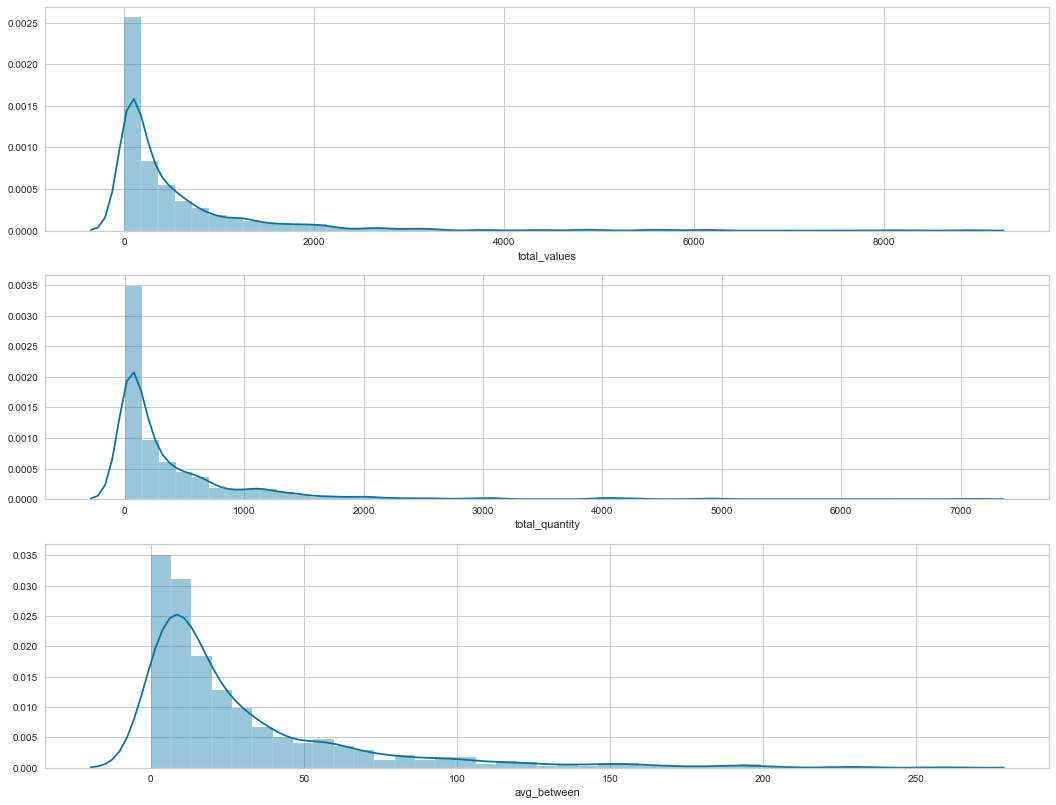

In [24]:
# Check the distribution of each features
plt.figure(figsize=(18,14))
plt.subplot(3,1,1); sns.distplot(valid_X2['total_values'])
plt.subplot(3,1,2); sns.distplot(valid_X2['total_quantity'])
plt.subplot(3,1,3); sns.distplot(valid_X2['avg_between'])
plt.show()

In [25]:
# Applying the log1p transformation to make the data more 'normal'
valid_X2_log = np.log1p(valid_X2)
valid_X2_log.head()

,total_values,total_quantity,avg_between
0,4.945421,4.770685,3.663562
1,3.386084,2.639057,4.430817
2,2.367436,1.386294,0.000000
3,5.067079,4.304065,3.610918
4,4.085976,4.248495,4.060443


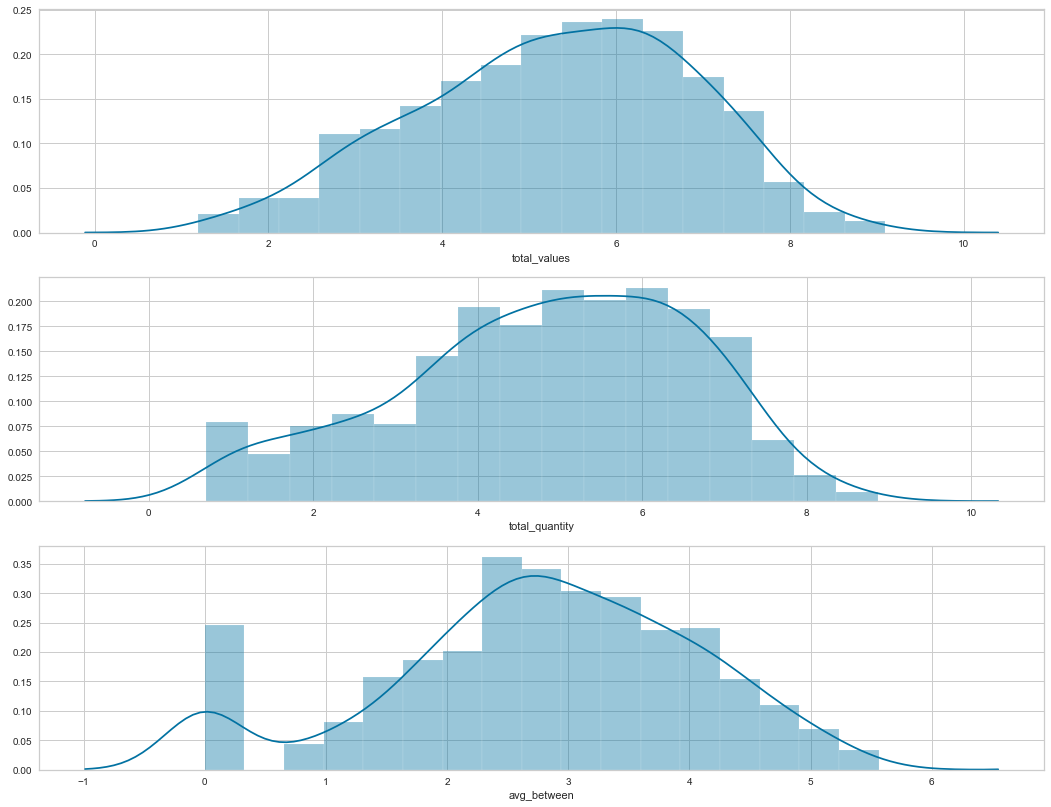

In [26]:
# Check the distribution of each features
plt.figure(figsize=(18,14))
plt.subplot(3,1,1); sns.distplot(valid_X2_log['total_values'])
plt.subplot(3,1,2); sns.distplot(valid_X2_log['total_quantity'])
plt.subplot(3,1,3); sns.distplot(valid_X2_log['avg_between'])
plt.show()

In [27]:
# Rescaling to remove the units
scaler = StandardScaler()
valid_X2_scaled = scaler.fit_transform(valid_X2_log)

# transform into a dataframe
valid_X2_scaled = pd.DataFrame(valid_X2_scaled, index=valid_X2_log.index, 
                         columns=valid_X2_log.columns)

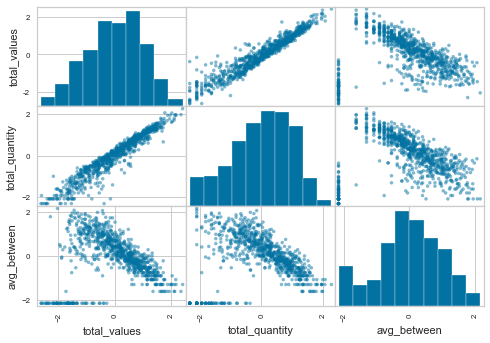

In [28]:
# Check the final distribution of each features
scatter = pd.plotting.scatter_matrix(valid_X2_scaled)

In [29]:
# Result
round(valid_X2_scaled.describe(),3)

,total_values,total_quantity,avg_between
count,836.000,836.000,836.000
mean,0.000,-0.000,0.000
std,1.001,1.001,1.001
min,-2.622,-2.336,-2.164
25%,-0.671,-0.659,-0.544
50%,0.076,0.092,0.044
75%,0.738,0.788,0.711
max,2.410,2.279,2.170


###### 7) Standardization of traditional data in train set

In [30]:
# Train + log + standardize
train_X2 = train[0].drop(columns=['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11'])
train_X2_log = np.log1p(train_X2)

scaler = StandardScaler()
train_X2_scaled = scaler.fit_transform(train_X2_log)

# transform into a dataframe
train_X2_scaled = pd.DataFrame(train_X2_scaled, index=train_X2_log.index, 
                         columns=train_X2_log.columns)
round(train_X2_scaled.describe(),3)

,total_values,total_quantity,avg_between
count,848.000,848.000,848.000
mean,-0.000,-0.000,-0.000
std,1.001,1.001,1.001
min,-2.816,-2.320,-2.227
25%,-0.721,-0.677,-0.572
50%,0.071,0.089,0.074
75%,0.744,0.799,0.729
max,2.423,2.291,1.975


In [31]:
# Check the Pearson correlations in traditonal date in train set
train_X2 = train[0].drop(columns=['f1','f2','f3','f4','f5',
                                'f6','f7','f8','f9','f10','f11'])
print(train_X2.describe())
corr = train_X2.corr()
corr 

       total_values  total_quantity  avg_between
count    848.000000      848.000000   848.000000
mean     553.155554      402.873821    29.707547
std      912.498902      678.827204    33.870290
min        1.350000        1.000000     0.000000
25%       62.435000       35.750000     7.000000
50%      219.675000      142.000000    17.000000
75%      634.940000      502.250000    40.000000
max     8914.410000     7076.000000   195.000000


,total_values,total_quantity,avg_between
total_values,1.000000,0.944726,-0.347511
total_quantity,0.944726,1.000000,-0.350100
avg_between,-0.347511,-0.350100,1.000000


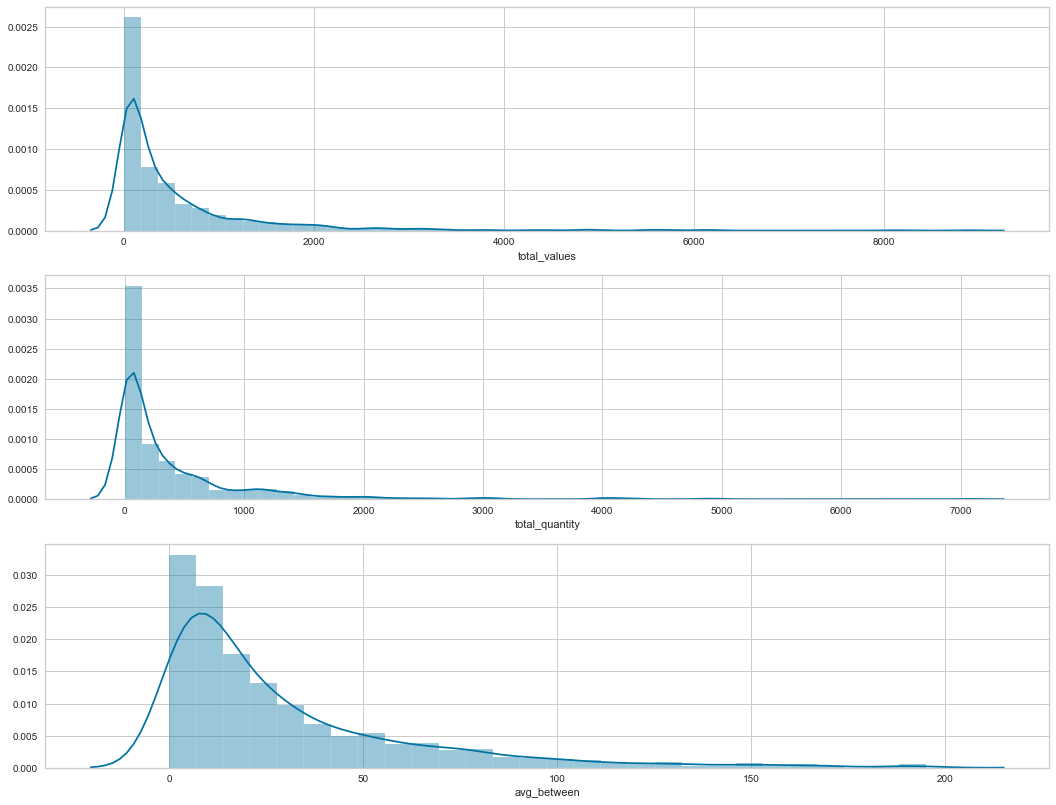

In [32]:
# Check the distribution of each features
plt.figure(figsize=(18,14))
plt.subplot(3,1,1); sns.distplot(train_X2['total_values'])
plt.subplot(3,1,2); sns.distplot(train_X2['total_quantity'])
plt.subplot(3,1,3); sns.distplot(train_X2['avg_between'])
plt.show()

In [33]:
# Applying the log1p transformation to make the data more 'normal'
train_X2_log = np.log1p(train_X2)
train_X2_log.head()

,total_values,total_quantity,avg_between
0,4.945421,4.770685,3.663562
1,6.847411,6.853299,1.609438
2,4.988662,4.290459,3.526361
3,4.396423,3.135494,2.833213
4,4.523852,4.330733,2.890372


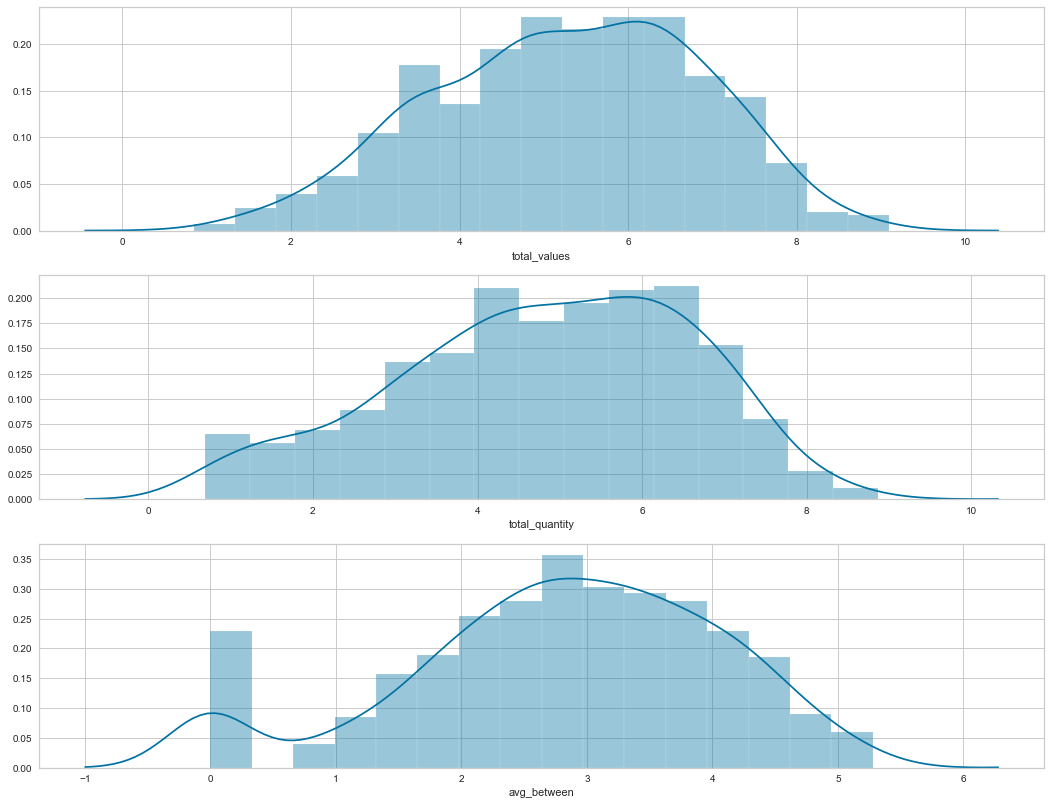

In [34]:
# Check the distribution of each features
plt.figure(figsize=(18,14))
plt.subplot(3,1,1); sns.distplot(train_X2_log['total_values'])
plt.subplot(3,1,2); sns.distplot(train_X2_log['total_quantity'])
plt.subplot(3,1,3); sns.distplot(train_X2_log['avg_between'])
plt.show()

In [35]:
# Rescaling to remove the units
scaler = StandardScaler()
train_X2_scaled = scaler.fit_transform(train_X2_log)

# transform into a dataframe
train_X2_scaled = pd.DataFrame(train_X2_scaled, index=train_X2_log.index, 
                         columns=train_X2_log.columns)

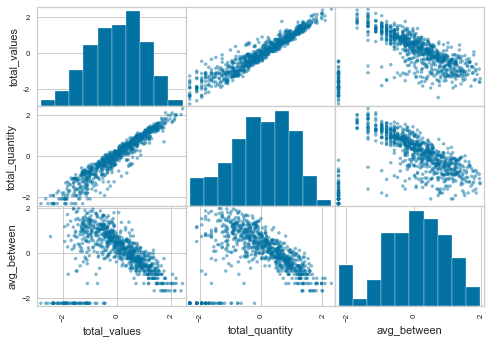

In [36]:
# Check the final distribution of each features
scatter = pd.plotting.scatter_matrix(train_X2_scaled)

In [37]:
# Result
round(train_X2_scaled.describe(),3)

,total_values,total_quantity,avg_between
count,848.000,848.000,848.000
mean,-0.000,-0.000,-0.000
std,1.001,1.001,1.001
min,-2.816,-2.320,-2.227
25%,-0.721,-0.677,-0.572
50%,0.071,0.089,0.074
75%,0.744,0.799,0.729
max,2.423,2.291,1.975


###### 8) Final code for validation set standardization

In [38]:
# valid temporal data standarization
valid_X = pd.DataFrame()

for i in valid[0].iloc[:,3:14].values:
    a = i - valid[0].iloc[:,3:14].values.sum()
    b = a / np.std(valid[0].iloc[:,3:14].values)
    #print(b)
    
    new_row = pd.DataFrame( [[b]] )
    valid_X = valid_X.append(new_row, ignore_index = True)

valid_X.columns = ['f']
valid_X = pd.DataFrame(valid_X.f.tolist(), 
                        columns=['f1','f2','f3','f4','f5','f6','f7','f8',
                                         'f9','f10','f11'])

# Valid + log + standardize
valid_X2 = valid[0].drop(columns=['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11'])
valid_X2_log = np.log1p(valid_X2)

scaler = StandardScaler()
valid_X2_scaled = scaler.fit_transform(valid_X2_log)

# transform into a dataframe
valid_X2_scaled = pd.DataFrame(valid_X2_scaled, index=valid_X2_log.index, 
                         columns=valid_X2_log.columns)
# Merge into final
final_valid = pd.concat([valid_X2_scaled, valid_X], axis=1)
final_valid = round(final_valid,2)
final_valid.head()

,total_values,total_quantity,avg_between,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11
0,-0.23,-0.03,0.69,-4779.88,-4779.79,-4779.79,-4779.41,-4779.96,-4779.85,-4779.78,-4779.96,-4779.96,-4779.96,-4779.96
1,-1.22,-1.24,1.29,-4779.89,-4779.96,-4779.96,-4779.96,-4779.96,-4779.89,-4779.96,-4779.93,-4779.96,-4779.96,-4779.96
2,-1.87,-1.94,-2.16,-4779.82,-4779.96,-4779.96,-4779.96,-4779.96,-4779.96,-4779.96,-4779.96,-4779.96,-4779.96,-4779.96
3,-0.15,-0.30,0.65,-4779.88,-4779.96,-4779.96,-4779.61,-4779.96,-4779.85,-4779.86,-4779.96,-4779.58,-4779.96,-4779.86
4,-0.78,-0.33,1.00,-4779.44,-4779.96,-4779.96,-4779.96,-4779.96,-4779.96,-4779.79,-4779.96,-4779.96,-4779.96,-4779.96


###### 9) Final code for train set standardization

In [39]:
# train temporal data standarization
train_X = pd.DataFrame()

for i in train[0].iloc[:,3:14].values:
    a = i - train[0].iloc[:,3:14].values.sum()
    b = a / np.std(train[0].iloc[:,3:14].values)
    #print(b)
    
    new_row = pd.DataFrame( [[b]] )
    train_X = train_X.append(new_row, ignore_index = True)

train_X.columns = ['f']
train_X = pd.DataFrame(train_X.f.tolist(), 
                        columns=['f1','f2','f3','f4','f5','f6','f7','f8',
                                         'f9','f10','f11'])

# Train + log + standardize
train_X2 = train[0].drop(columns=['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11'])
train_X2_log = np.log1p(train_X2)

scaler = StandardScaler()
train_X2_scaled = scaler.fit_transform(train_X2_log)

# transform into a dataframe
train_X2_scaled = pd.DataFrame(train_X2_scaled, index=train_X2_log.index, 
                         columns=train_X2_log.columns)
# Merge into final
final_train = pd.concat([train_X2_scaled, train_X], axis=1)
final_train = round(final_train,2)
final_train.head()

,total_values,total_quantity,avg_between,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11
0,-0.22,-0.02,0.69,-4787.07,-4787.07,-4786.69,-4787.24,-4787.13,-4787.06,-4787.24,-4787.24,-4787.24,-4787.24,-4787.24
1,0.99,1.16,-0.95,-4786.29,-4786.49,-4786.46,-4786.23,-4786.18,-4786.41,-4786.36,-4786.79,-4786.27,-4786.56,-4786.48
2,-0.19,-0.29,0.58,-4787.16,-4786.78,-4787.24,-4787.24,-4787.24,-4786.86,-4787.11,-4787.24,-4786.97,-4787.10,-4786.86
3,-0.56,-0.94,0.03,-4786.98,-4787.14,-4787.18,-4787.24,-4787.24,-4787.24,-4787.24,-4787.24,-4787.24,-4787.24,-4787.24
4,-0.48,-0.27,0.07,-4787.04,-4787.15,-4787.12,-4787.18,-4787.24,-4787.24,-4787.24,-4787.24,-4787.24,-4787.24,-4787.24


# C. Optimizing three model's meta-parameters

### 1. Data preparation for RandomizedSearchCV

In [ ]:
ws = 33
ows = 33
now = 609
    # for each holdout set, compute f1 score

valid = get_dataset_value(now-2*ows, ws, ows)
train = get_dataset_value(now-3*ows, ws, ows)

         # output feature changes to binary, 1: non- churn, 0: churn
valid[1][valid[1]>0] = 1 # non-chrun
train[1][train[1]>0] = 1 # non-chrun
        
        # Balancing unbalanced output feature in train data set using SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(train[0], train[1])
        
X_train = pd.DataFrame(X_train,
                      columns=['total_values','total_quantity','avg_between',
                              'f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11'])
y_train = pd.DataFrame(y_train)
        
        # standardizing Temporal data in train set
train_X = pd.DataFrame()

for i in X_train.iloc[:,3:14].values:
        a = i - X_train.iloc[:,3:14].values.sum()
        b = a / np.std(X_train.iloc[:,3:14].values)
    
        new_row = pd.DataFrame( [[b]] )
        train_X = train_X.append(new_row, ignore_index = True)

train_X.columns = ['f']
train_X = pd.DataFrame(train_X.f.tolist(), 
                            columns=['f1','f2','f3','f4','f5','f6','f7','f8',
                                         'f9','f10','f11'])

        # standardizing traditional data in train set
        # Step 1: log1p
train_X2 = X_train.drop(columns=['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11'])
train_X2_log = np.log1p(train_X2)
        # Step 2: StandardScaler
scaler = StandardScaler()
train_X2_scaled = scaler.fit_transform(train_X2_log)

        # transform into a dataframe
train_X2_scaled = pd.DataFrame(train_X2_scaled, index=train_X2_log.index, 
                             columns=train_X2_log.columns)
final_train = pd.concat([train_X2_scaled, train_X], axis=1)
final_train = round(final_train,2)
        
        # # standardizing Temporal data in validation set
valid_X = pd.DataFrame()

for i in valid[0].iloc[:,3:14].values:
        a = i - valid[0].iloc[:,3:14].values.sum()
        b = a / np.std(valid[0].iloc[:,3:14].values)
    
        new_row = pd.DataFrame( [[b]] )
        valid_X = valid_X.append(new_row, ignore_index = True)

valid_X.columns = ['f']
valid_X = pd.DataFrame(valid_X.f.tolist(), 
                            columns=['f1','f2','f3','f4','f5','f6','f7','f8',
                                         'f9','f10','f11'])

        # standardizing traditional data in validation set
        # Step 1: log1p
valid_X2 = valid[0].drop(columns=['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11'])
valid_X2_log = np.log1p(valid_X2)
        # Step 2: StandardScaler
scaler = StandardScaler()
valid_X2_scaled = scaler.fit_transform(valid_X2_log)

        # transform into a dataframe
valid_X2_scaled = pd.DataFrame(valid_X2_scaled, index=valid_X2_log.index, 
                             columns=valid_X2_log.columns)
        # Merge into final
final_valid = pd.concat([valid_X2_scaled, valid_X], axis=1)
final_valid = round(final_valid,2)

### 2. Logistic Regression RamdomizedSearchCV 

###### 1) Logistic RandomizedSearchCV 

In [41]:
np.random.seed(42)

c_space = np.logspace(-10, 10, 20) 
penalty = ['l1', 'l2']
param_grid = {'C': c_space,
             'penalty':penalty}

lf = LogisticRegression(solver = 'liblinear', random_state=42) 
lf_cv = RandomizedSearchCV(lf, param_grid, cv = 10, n_jobs=-1, random_state=42) 
lf_cv.fit(final_train, y_train) 
print('Best Params of Logistic:', lf_cv.best_params_)
print('=========================================================')
print('Best training accuracy: ', round(lf_cv.best_score_,3))
y_pred = lf_cv.predict(final_valid)
f1 = f1_score(valid[1], y_pred)
accuray = accuracy_score(valid[1], y_pred) 
print('Best validation accuracy: ', round(accuray,3))
print('=========================================================')
print('Valid set f1 score for best params:', round(f1,3))
print('=========================================================')
print('Confusion Matrix')
confusion = pd.DataFrame(confusion_matrix(valid[1], y_pred, labels=[1,0]),
                        index=['y_true Yes','y_ture No'],
                        columns=['y_predict Yes','y_predict No'])
print(confusion)

Best Params of Logistic: {'penalty': 'l2', 'C': 0.002335721469090121}
Best training accuracy:  0.82
Best validation accuracy:  0.77
Valid set f1 score for best params: 0.786
Confusion Matrix
            y_predict Yes  y_predict No
y_true Yes            352           121
y_ture No              71           292


###### 2) Optimized logistic regression model

In [42]:
# Finall Logistic model
lf = LogisticRegression(solver = 'liblinear', random_state=42,
                       penalty = 'l2', C= 0.002335721469090121) 

###### 3) ROC curve and AUC score

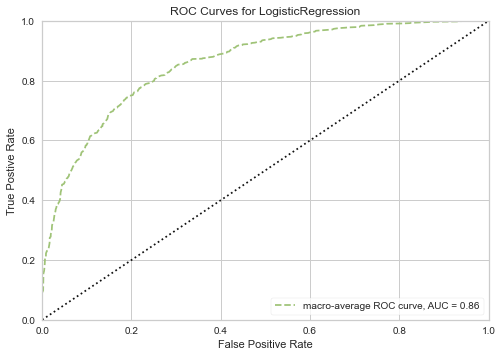

roc_auc_score: 0.774


In [45]:
visualizer = ROCAUC(lf, classes=[0, 1], micro=False, macro=True, per_class=False)
visualizer.fit(final_train, y_train)
visualizer.score(final_valid, valid[1])
visualizer.show()
print('roc_auc_score:', round(roc_auc_score(valid[1], y_pred),3))

### 3. GradientBoostingClassifier RamdomSearchCV 

###### 1) GBM RandomizedSearchCV 1

In [46]:
# RandomizedSearchCV 1

np.random.seed(42)

learning_rate = np.random.uniform(0, 1, 10) 
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 30)]
min_samples_split = [int(x) for x in np.linspace(2,100,10)] 
min_samples_leaf = [int(x) for x in np.linspace(2,100,10)]
max_depth = [int(x) for x in np.linspace(1,10, num=10)]
subsample = np.random.uniform(0, 1, 20) 

param_grid = {'learning_rate': learning_rate,
             'n_estimators':n_estimators,
             'min_samples_split':min_samples_split,
             'min_samples_leaf':min_samples_leaf,
             'max_depth':max_depth,
             'subsample':subsample}

In [47]:
bgc = GradientBoostingClassifier(random_state=42)
bgc_cv = RandomizedSearchCV(bgc, param_grid, cv = 5, n_jobs=-1, random_state=42) 
bgc_cv.fit(final_train, y_train) 
print('Best Params of GBM:', bgc_cv.best_params_)
print('=========================================================')
print('Best training accuracy: ', round(bgc_cv.best_score_,3))
y_pred = bgc_cv.predict(final_valid)
f1 = f1_score(valid[1], y_pred)
accuray = accuracy_score(valid[1], y_pred) 
print('Best validation accuracy: ', round(accuray,3))
print('=========================================================')
print('Valid set f1 score for best params:', round(f1,3))
print('=========================================================')
print('Confusion Matrix')
confusion = pd.DataFrame(confusion_matrix(valid[1], y_pred, labels=[1,0]),
                        index=['y_true Yes','y_ture No'],
                        columns=['y_predict Yes','y_predict No'])
print(confusion)

Best Params of GBM: {'subsample': 0.5247564316322378, 'n_estimators': 487, 'min_samples_split': 12, 'min_samples_leaf': 45, 'max_depth': 8, 'learning_rate': 0.05808361216819946}
Best training accuracy:  0.813
Best validation accuracy:  0.727
Valid set f1 score for best params: 0.702
Confusion Matrix
            y_predict Yes  y_predict No
y_true Yes            268           205
y_ture No              23           340


###### 2) GBM RandomizedSearchCV 2 (narrow)

In [48]:
# RandomizedSearchCV 2

np.random.seed(42)

learning_rate = np.random.uniform(0, 0.5, 10) 
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 600, num = 30)]
min_samples_split = [int(x) for x in np.linspace(5,20,10)] 
min_samples_leaf = [int(x) for x in np.linspace(30,60,10)]
max_depth = [int(x) for x in np.linspace(5,12, num=5)]
subsample = np.random.uniform(0.3, 0.7, 20) 

param_grid = {'learning_rate': learning_rate,
             'n_estimators':n_estimators,
             'min_samples_split':min_samples_split,
             'min_samples_leaf':min_samples_leaf,
             'max_depth':max_depth,
             'subsample':subsample}

In [49]:
bgc = GradientBoostingClassifier(random_state=42)
bgc_cv = RandomizedSearchCV(bgc, param_grid, cv = 5, n_jobs=-1, random_state=42) 
bgc_cv.fit(final_train, y_train) 
print('Best Params of GBM:', bgc_cv.best_params_)
print('=========================================================')
print('Best training accuracy: ', round(bgc_cv.best_score_,3))
y_pred = bgc_cv.predict(final_valid)
f1 = f1_score(valid[1], y_pred)
accuray = accuracy_score(valid[1], y_pred) 
print('Best validation accuracy: ', round(accuray,3))
print('=========================================================')
print('Valid set f1 score for best params:', round(f1,3))
print('=========================================================')
print('Confusion Matrix')
confusion = pd.DataFrame(confusion_matrix(valid[1], y_pred, labels=[1,0]),
                        index=['y_true Yes','y_ture No'],
                        columns=['y_predict Yes','y_predict No'])
print(confusion)

Best Params of GBM: {'subsample': 0.38493564427131044, 'n_estimators': 296, 'min_samples_split': 6, 'min_samples_leaf': 36, 'max_depth': 10, 'learning_rate': 0.07799726016810132}
Best training accuracy:  0.817
Best validation accuracy:  0.744
Valid set f1 score for best params: 0.727
Confusion Matrix
            y_predict Yes  y_predict No
y_true Yes            285           188
y_ture No              26           337


###### 3) Final GradientBoostingClassifier model

In [50]:
# Final model
bgm = GradientBoostingClassifier(random_state=42,
                                subsample= 0.38493564427131044, n_estimators= 296, 
                                min_samples_split= 6, min_samples_leaf= 36, 
                                max_depth= 10, learning_rate= 0.07799726016810132)

###### 4) ROC curve and AUC score

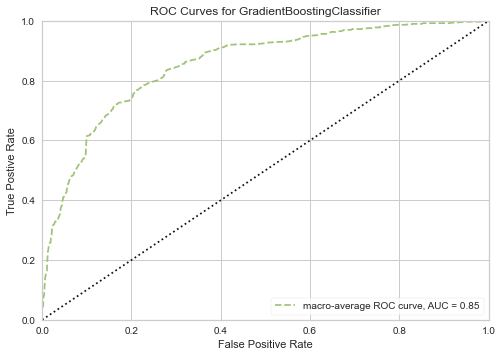

roc_auc_score: 0.765


In [51]:
visualizer = ROCAUC(bgm, classes=[0, 1], micro=False, macro=True, per_class=False)
visualizer.fit(final_train, y_train)
visualizer.score(final_valid, valid[1])
visualizer.show()
print('roc_auc_score:', round(roc_auc_score(valid[1], y_pred),3))

### 4. XGBoost classifier

###### 1) XGB RandomizedSearchCV 1

In [52]:
# RandomizedSearchCV 1

np.random.seed(42)

min_child_weight = [int(x) for x in np.linspace(1,10, num=10)]
max_depth = [int(x) for x in np.linspace(1,10, num=10)]
subsample = np.random.uniform(0, 1, 20) 
gamma = np.logspace(-10, 10, 20) 
colsample_bytree = np.random.uniform(0, 1, 20) 
learning_rate = np.random.uniform(0, 1, 10) 
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 30)]

param_grid = {'min_child_weight': min_child_weight,
             'max_depth':max_depth,
             'subsample':subsample,
             'gamma':gamma,
             'colsample_bytree':colsample_bytree,
             'learning_rate': learning_rate,
             'n_estimators':n_estimators}

In [53]:
import xgboost as xgb
xgb = xgb.XGBClassifier(objective='binary:logistic',
                    silent=True, nthread=1, random_state=42, n_jobs=-1)
xgb_cv = RandomizedSearchCV(xgb, param_grid, cv = 5, n_jobs=-1, random_state=42) 
xgb_cv.fit(final_train, y_train) 
print('Best Params of XGBClassifier:', xgb_cv.best_params_)
print('=========================================================')
print('Best training accuracy  : ', round(xgb_cv.best_score_,3))
y_pred = xgb_cv.predict(final_valid)
f1 = f1_score(valid[1], y_pred)
accuray = accuracy_score(valid[1], y_pred) 
print('Best validation accuracy: ', round(accuray,3))
print('=========================================================')
print('Valid set f1 score for best params:', round(f1,3))
print('=========================================================')
print('Confusion Matrix')
confusion = pd.DataFrame(confusion_matrix(valid[1], y_pred, labels=[1,0]),
                        index=['y_true Yes','y_ture No'],
                        columns=['y_predict Yes','y_predict No'])
print(confusion)

Best Params of XGBClassifier: {'subsample': 0.43194501864211576, 'n_estimators': 931, 'min_child_weight': 6, 'max_depth': 6, 'learning_rate': 0.034388521115218396, 'gamma': 0.026366508987303555, 'colsample_bytree': 0.9488855372533332}
Best training accuracy  :  0.823
Best validation accuracy:  0.754
Valid set f1 score for best params: 0.744
Confusion Matrix
            y_predict Yes  y_predict No
y_true Yes            299           174
y_ture No              32           331


###### 2) XGB RandomizedSearchCV 2 (narrow)

In [54]:
# RandomizedSearchCV 2

np.random.seed(42)

min_child_weight = [int(x) for x in np.linspace(4,8, num=5)]
max_depth = [int(x) for x in np.linspace(4,8, num=5)]
subsample = np.random.uniform(0.2, 0.6, 20) 
gamma = np.logspace(-10, 10, 20) 
colsample_bytree = np.random.uniform(0.6, 1, 20) 
learning_rate = np.random.uniform(0, 0.5, 20) 
n_estimators = [int(x) for x in np.linspace(start = 500, stop = 1000, num = 30)]

param_grid = {'min_child_weight': min_child_weight,
             'max_depth':max_depth,
             'subsample':subsample,
             'gamma':gamma,
             'colsample_bytree':colsample_bytree,
             'learning_rate': learning_rate,
             'n_estimators':n_estimators}

In [55]:
import xgboost as xgb
xgb = xgb.XGBClassifier(objective='binary:logistic',
                    silent=True, nthread=1, random_state=42, n_jobs=-1)
xgb_cv = RandomizedSearchCV(xgb, param_grid, cv = 5, n_jobs=-1, random_state=42) 
xgb_cv.fit(final_train, y_train) 
print('Best Params of XGBClassifier:', xgb_cv.best_params_)
print('=========================================================')
print('Best training accuracy  : ', round(xgb_cv.best_score_,3))
y_pred = xgb_cv.predict(final_valid)
f1 = f1_score(valid[1], y_pred)
accuray = accuracy_score(valid[1], y_pred) 
print('Best validation accuracy: ', round(accuray,3))
print('=========================================================')
print('Valid set f1 score for best params:', round(f1,3))
print('=========================================================')
print('Confusion Matrix')
confusion = pd.DataFrame(confusion_matrix(valid[1], y_pred, labels=[1,0]),
                        index=['y_true Yes','y_ture No'],
                        columns=['y_predict Yes','y_predict No'])
print(confusion)

Best Params of XGBClassifier: {'subsample': 0.20823379771832098, 'n_estimators': 862, 'min_child_weight': 8, 'max_depth': 5, 'learning_rate': 0.017194260557609198, 'gamma': 0.2976351441631313, 'colsample_bytree': 0.7824279936868144}
Best training accuracy  :  0.821
Best validation accuracy:  0.786
Valid set f1 score for best params: 0.811
Confusion Matrix
            y_predict Yes  y_predict No
y_true Yes            385            88
y_ture No              91           272


###### 3) XGB RandomizedSearchCV result

In [57]:
# After RandomizedsearchCV
import xgboost as xgb
xgb = xgb.XGBClassifier(objective='binary:logistic',
                    silent=True, nthread=1, random_state=42, n_jobs=-1,
                    subsample= 0.20823379771832098, n_estimators= 862, 
                    min_child_weight= 8, max_depth= 5, 
                    learning_rate= 0.017194260557609198, gamma= 0.2976351441631313, 
                    colsample_bytree= 0.7824279936868144)

###### 4) Selecting the best 'min_child_weight' meta-parameter based on RandomizedSearchCV result

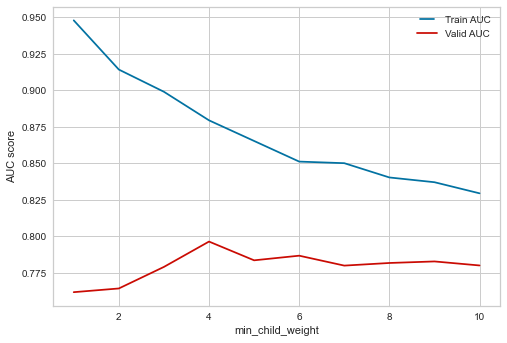

In [58]:
# Selecting the best 'min_child_weight' meta-parameter 
# by comparing train and valid set's AUC score

min_child_weight = [10,9,8,7,6,5,4,3,2,1]

train_results = []
valid_results = []

for i in min_child_weight:
    import xgboost as xgb
    xgb = xgb.XGBClassifier(objective='binary:logistic',
                    silent=True, nthread=1, random_state=42, n_jobs=-1,
                    subsample= 0.20823379771832098, n_estimators= 862, 
                    min_child_weight= i, max_depth= 5, 
                    learning_rate= 0.017194260557609198, gamma= 0.2976351441631313, 
                    colsample_bytree= 0.7824279936868144)
    xgb.fit(final_train, y_train)
    
    train_pred = xgb.predict(final_train)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    valid_pred = xgb.predict(final_valid)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(valid[1], valid_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    valid_results.append(roc_auc)
    
line1, = plt.plot(min_child_weight, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_child_weight, valid_results, 'r', label='Valid AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=22)})
plt.ylabel('AUC score')
plt.xlabel('min_child_weight')
plt.show() 

###### 5) Selecting the best 'max_depth' meta-parameter based on RandomizedSearchCV result

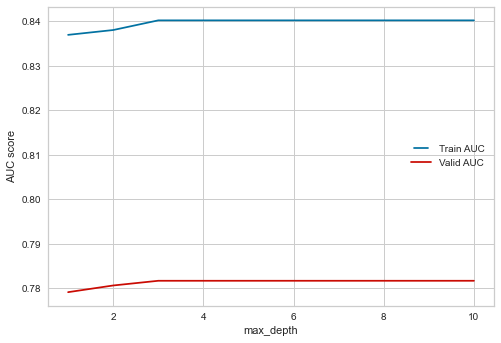

In [59]:
# Selecting the best 'max_depth' meta-parameter 
# by comparing train and valid set's AUC score

max_depth = [10,9,8,7,6,5,4,3,2,1]

train_results = []
valid_results = []

for i in max_depth:
    import xgboost as xgb
    xgb = xgb.XGBClassifier(objective='binary:logistic',
                    silent=True, nthread=1, random_state=42, n_jobs=-1,
                    subsample= 0.20823379771832098, n_estimators= 862, 
                    min_child_weight= 8, max_depth= i, 
                    learning_rate= 0.017194260557609198, gamma= 0.2976351441631313, 
                    colsample_bytree= 0.7824279936868144)
    xgb.fit(final_train, y_train)
    
    train_pred = xgb.predict(final_train)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    valid_pred = xgb.predict(final_valid)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(valid[1], valid_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    valid_results.append(roc_auc)
    
line1, = plt.plot(max_depth, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depth, valid_results, 'r', label='Valid AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=22)})
plt.ylabel('AUC score')
plt.xlabel('max_depth')
plt.show() 

###### 6) Selecting the best 'subsample' meta-parameter based on RandomizedSearchCV result

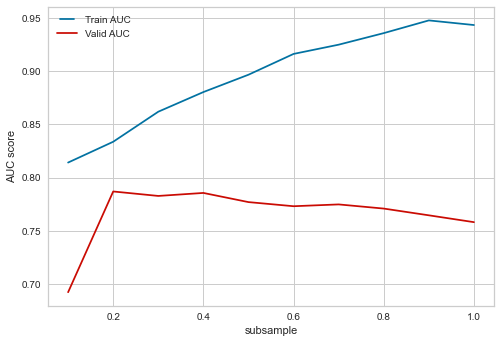

In [60]:
# Selecting the best 'subsample' meta-parameter 
# by comparing train and valid set's AUC score

subsample = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]

train_results = []
valid_results = []

for i in subsample:
    import xgboost as xgb
    xgb = xgb.XGBClassifier(objective='binary:logistic',
                    silent=True, nthread=1, random_state=42, n_jobs=-1,
                    subsample= i, n_estimators= 862, 
                    min_child_weight= 8, max_depth= 5, 
                    learning_rate= 0.017194260557609198, gamma= 0.2976351441631313, 
                    colsample_bytree= 0.7824279936868144)
    xgb.fit(final_train, y_train)
    
    train_pred = xgb.predict(final_train)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    valid_pred = xgb.predict(final_valid)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(valid[1], valid_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    valid_results.append(roc_auc)
    
line1, = plt.plot(subsample, train_results, 'b', label='Train AUC')
line2, = plt.plot(subsample, valid_results, 'r', label='Valid AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=22)})
plt.ylabel('AUC score')
plt.xlabel('subsample')
plt.show() 

###### 7) Selecting the best 'gamma' meta-parameter based on RandomizedSearchCV result

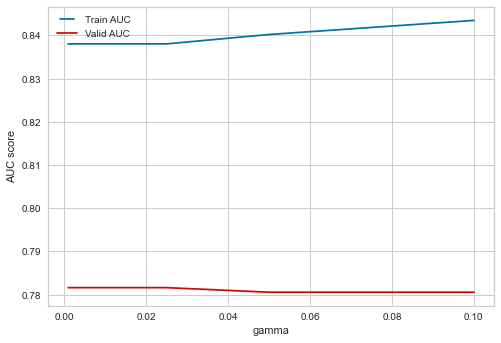

In [61]:
# Selecting the best 'gamma' meta-parameter 
# by comparing train and valid set's AUC score

gamma = [0.1, 0.05, 0.025, 0.01, 0.005, 0.0025, 0.001]

train_results = []
valid_results = []

for i in gamma:
    import xgboost as xgb
    xgb = xgb.XGBClassifier(objective='binary:logistic',
                    silent=True, nthread=1, random_state=42, n_jobs=-1,
                    subsample= 0.20823379771832098, n_estimators= 862, 
                    min_child_weight= 8, max_depth= 5, 
                    learning_rate= 0.017194260557609198, gamma= i, 
                    colsample_bytree= 0.7824279936868144)
    xgb.fit(final_train, y_train)
    
    train_pred = xgb.predict(final_train)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    valid_pred = xgb.predict(final_valid)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(valid[1], valid_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    valid_results.append(roc_auc)
    
line1, = plt.plot(gamma, train_results, 'b', label='Train AUC')
line2, = plt.plot(gamma, valid_results, 'r', label='Valid AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=22)})
plt.ylabel('AUC score')
plt.xlabel('gamma')
plt.show() 

###### 8) Selecting the best 'colsample_bytree' meta-parameter based on RandomizedSearchCV result

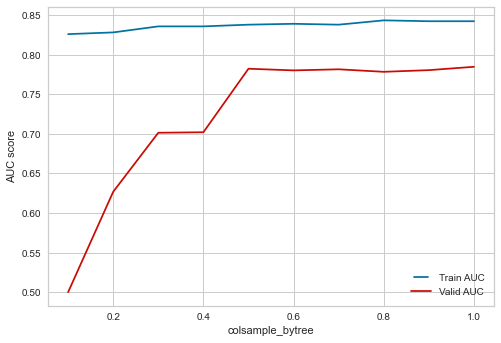

In [62]:
# Selecting the best 'colsample_bytree' meta-parameter 
# by comparing train and valid set's AUC score

colsample_bytree = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]

train_results = []
valid_results = []

for i in colsample_bytree:
    import xgboost as xgb
    xgb = xgb.XGBClassifier(objective='binary:logistic',
                    silent=True, nthread=1, random_state=42, n_jobs=-1,
                    subsample= 0.20823379771832098, n_estimators= 862, 
                    min_child_weight= 8, max_depth= 5, 
                    learning_rate= 0.017194260557609198, gamma= 0.2976351441631313, 
                    colsample_bytree= i)
    xgb.fit(final_train, y_train)
    
    train_pred = xgb.predict(final_train)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    valid_pred = xgb.predict(final_valid)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(valid[1], valid_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    valid_results.append(roc_auc)
    
line1, = plt.plot(colsample_bytree, train_results, 'b', label='Train AUC')
line2, = plt.plot(colsample_bytree, valid_results, 'r', label='Valid AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=22)})
plt.ylabel('AUC score')
plt.xlabel('colsample_bytree')
plt.show() 

###### 9) Selecting the best 'learning_rates' meta-parameter based on RandomizedSearchCV result 

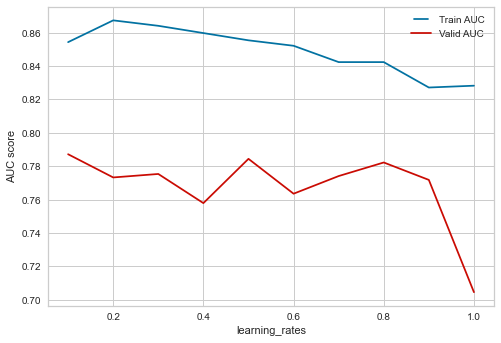

In [63]:
# Selecting the best 'learning_rates' meta-parameter 
# by comparing train and valid set's AUC score

learning_rates = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]

train_results = []
valid_results = []

for i in learning_rates:
    import xgboost as xgb
    xgb = xgb.XGBClassifier(objective='binary:logistic',
                    silent=True, nthread=1, random_state=42, n_jobs=-1,
                    subsample= 0.20823379771832098, n_estimators= 862, 
                    min_child_weight= 8, max_depth= 5, 
                    learning_rate= i, gamma= 0.2976351441631313, 
                    colsample_bytree= 0.7824279936868144)
    xgb.fit(final_train, y_train)
    
    train_pred = xgb.predict(final_train)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    valid_pred = xgb.predict(final_valid)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(valid[1], valid_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    valid_results.append(roc_auc)
    
line1, = plt.plot(learning_rates, train_results, 'b', label='Train AUC')
line2, = plt.plot(learning_rates, valid_results, 'r', label='Valid AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=22)})
plt.ylabel('AUC score')
plt.xlabel('learning_rates')
plt.show() 

###### 9) Selecting the best 'estimators' meta-parameter based on RandomizedSearchCV result 

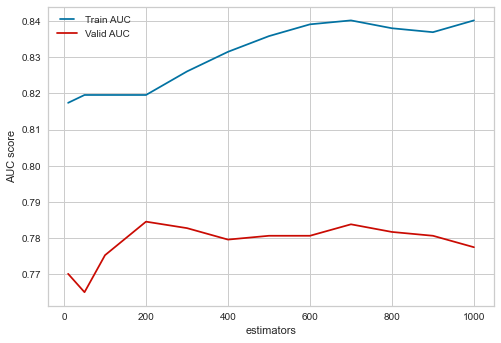

In [64]:
# Selecting the best 'estimators' meta-parameter 
# by comparing train and valid set's AUC score

estimators = [10, 50, 100, 150, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

train_results = []
valid_results = []

for i in estimators:
    import xgboost as xgb
    xgb = xgb.XGBClassifier(objective='binary:logistic',
                    silent=True, nthread=1, random_state=42, n_jobs=-1,
                    subsample= 0.20823379771832098, n_estimators= i, 
                    min_child_weight= 8, max_depth= 5, 
                    learning_rate= 0.017194260557609198, gamma= 0.2976351441631313, 
                    colsample_bytree= 0.7824279936868144)
    xgb.fit(final_train, y_train)
    
    train_pred = xgb.predict(final_train)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    valid_pred = xgb.predict(final_valid)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(valid[1], valid_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    valid_results.append(roc_auc)
    
line1, = plt.plot(estimators, train_results, 'b', label='Train AUC')
line2, = plt.plot(estimators, valid_results, 'r', label='Valid AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=22)})
plt.ylabel('AUC score')
plt.xlabel('estimators')
plt.show() 

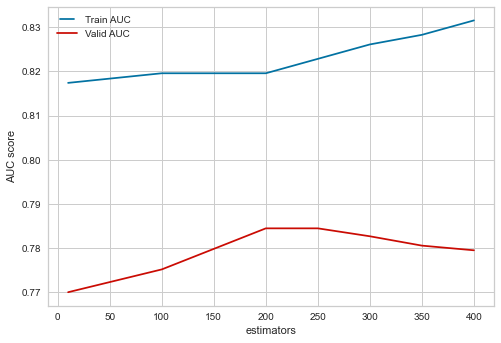

In [66]:
estimators = [10, 100, 150, 200, 250, 300, 350, 400]

train_results = []
valid_results = []

for i in estimators:
    import xgboost as xgb
    xgb = xgb.XGBClassifier(objective='binary:logistic',
                    silent=True, nthread=1, random_state=42, n_jobs=-1,
                    subsample= 0.20823379771832098, n_estimators= i, 
                    min_child_weight= 8, max_depth= 5, 
                    learning_rate= 0.017194260557609198, gamma= 0.2976351441631313, 
                    colsample_bytree= 0.7824279936868144)
    xgb.fit(final_train, y_train)
    
    train_pred = xgb.predict(final_train)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    valid_pred = xgb.predict(final_valid)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(valid[1], valid_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    valid_results.append(roc_auc)
    
line1, = plt.plot(estimators, train_results, 'b', label='Train AUC')
line2, = plt.plot(estimators, valid_results, 'r', label='Valid AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=22)})
plt.ylabel('AUC score')
plt.xlabel('estimators')
plt.show() 

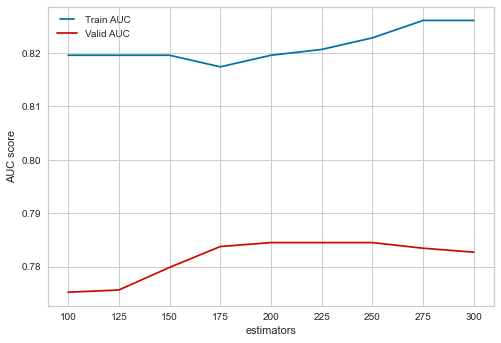

In [65]:
estimators = [100, 125, 150, 175, 200, 225, 250, 275, 300]

train_results = []
valid_results = []

for i in estimators:
    import xgboost as xgb
    xgb = xgb.XGBClassifier(objective='binary:logistic',
                    silent=True, nthread=1, random_state=42, n_jobs=-1,
                    subsample= 0.20823379771832098, n_estimators= i, 
                    min_child_weight= 8, max_depth= 5, 
                    learning_rate= 0.017194260557609198, gamma= 0.2976351441631313, 
                    colsample_bytree= 0.7824279936868144)
    xgb.fit(final_train, y_train)
    
    train_pred = xgb.predict(final_train)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    valid_pred = xgb.predict(final_valid)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(valid[1], valid_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    valid_results.append(roc_auc)
    
line1, = plt.plot(estimators, train_results, 'b', label='Train AUC')
line2, = plt.plot(estimators, valid_results, 'r', label='Valid AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=22)})
plt.ylabel('AUC score')
plt.xlabel('estimators')
plt.show() 

###### 10) Result of comparing each meta-parameter with train and validation AUC score

In [67]:
import xgboost as xgb
xgb = xgb.XGBClassifier(objective='binary:logistic',
                    silent=True, nthread=1, random_state=42, n_jobs=-1,
                    subsample= 0.2, n_estimators= 175, 
                    min_child_weight= 4, max_depth= 3, 
                    learning_rate= 0.5, gamma= 0.025, 
                    colsample_bytree= 0.5)

xgb.fit(final_train, y_train) 

print("train set accuracy: {:.3f}".format(xgb.score(final_train, y_train)))
print("valid set accuracy : {:.3f}".format(xgb.score(final_valid, valid[1])))
print('=========================================================')
y_pred = xgb.predict(final_valid)
f1 = f1_score(valid[1], y_pred)
print('Valid set f1 score for best params:', round(f1,3))
print('=========================================================')
print('Confusion Matrix')
confusion = pd.DataFrame(confusion_matrix(valid[1], y_pred, labels=[1,0]),
                        index=['y_true Yes','y_ture No'],
                        columns=['y_predict Yes','y_predict No'])
print(confusion)

train set accuracy: 0.867
valid set accuracy : 0.778
Valid set f1 score for best params: 0.801
Confusion Matrix
            y_predict Yes  y_predict No
y_true Yes            375            98
y_ture No              88           275


###### 11) ROC curve and AUC score

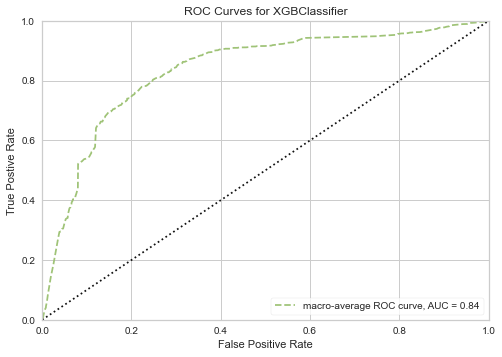

roc_auc_score: 0.775


In [68]:
visualizer = ROCAUC(xgb, classes=[0, 1], micro=False, macro=True, per_class=False)
visualizer.fit(final_train, y_train)
visualizer.score(final_valid, valid[1])
visualizer.show()
print('roc_auc_score:', round(roc_auc_score(valid[1], y_pred),3))

###### 12) FInal XGBoost Classifier model from RandomizedSearchCV

In [69]:
# final model of XGB
import xgboost as xgb
xgb = xgb.XGBClassifier(objective='binary:logistic',
                    silent=True, nthread=1, random_state=42, n_jobs=-1,
                    subsample= 0.20823379771832098, n_estimators= 862, 
                    min_child_weight= 8, max_depth= 5, 
                    learning_rate= 0.017194260557609198, gamma= 0.2976351441631313, 
                    colsample_bytree= 0.7824279936868144)

xgb.fit(final_train, y_train) 

print("train set accuracy: {:.3f}".format(xgb.score(final_train, y_train)))
print("valid set accuracy : {:.3f}".format(xgb.score(final_valid, valid[1])))
print('=========================================================')
y_pred = xgb.predict(final_valid)
f1 = f1_score(valid[1], y_pred)
print('Valid set f1 score for best params:', round(f1,3))
print('=========================================================')
print('Confusion Matrix')
confusion = pd.DataFrame(confusion_matrix(valid[1], y_pred, labels=[1,0]),
                        index=['y_true Yes','y_ture No'],
                        columns=['y_predict Yes','y_predict No'])
print(confusion)

train set accuracy: 0.840
valid set accuracy : 0.786
Valid set f1 score for best params: 0.811
Confusion Matrix
            y_predict Yes  y_predict No
y_true Yes            385            88
y_ture No              91           272


###### 13) ROC curve and AUC score

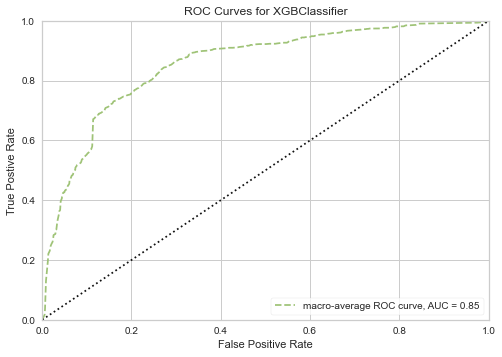

roc_auc_score: 0.782


In [70]:
visualizer = ROCAUC(xgb, classes=[0, 1], micro=False, macro=True, per_class=False)
visualizer.fit(final_train, y_train)
visualizer.score(final_valid, valid[1])
visualizer.show()
print('roc_auc_score:', round(roc_auc_score(valid[1], y_pred),3))

###### 14) Final model 

In [71]:
# final model of XGB
import xgboost as xgb
xgb = xgb.XGBClassifier(objective='binary:logistic',
                    silent=True, nthread=1, random_state=42, n_jobs=-1,
                    subsample= 0.20823379771832098, n_estimators= 862, 
                    min_child_weight= 8, max_depth= 5, 
                    learning_rate= 0.017194260557609198, gamma= 0.2976351441631313, 
                    colsample_bytree= 0.7824279936868144)

# D. Selecting the best model

### 1. Function for getting prediction score of three models

In [203]:
def predicting_top_three_models(model, total_holdout_sets, now, ws, ows):
    f1_scores = []
    valid_accuracy = []
    train_accuracy = []
    
    # for each holdout set, compute f1 score
    for i in range(total_holdout_sets):
        valid = get_dataset_value(now-2*ows, ws, ows)
        train = get_dataset_value(now-3*ows, ws, ows)

         # output feature changes to binary, 1: non- churn, 0: churn
        valid[1][valid[1]>0] = 1 # non-chrun
        train[1][train[1]>0] = 1 # non-chrun
        
        # Balancing unbalanced output feature in train data set using SMOTE
        smote = SMOTE(random_state=42)
        X_train, y_train = smote.fit_resample(train[0], train[1])
        
        X_train = pd.DataFrame(X_train,
                      columns=['total_values','total_quantity','avg_between',
                              'f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11'])
        y_train = pd.DataFrame(y_train)
        
        # standardizing Temporal data in train set
        train_X = pd.DataFrame()

        for i in X_train.iloc[:,3:14].values:
            a = i - X_train.iloc[:,3:14].values.sum()
            b = a / np.std(X_train.iloc[:,3:14].values)
    
            new_row = pd.DataFrame( [[b]] )
            train_X = train_X.append(new_row, ignore_index = True)

        train_X.columns = ['f']
        train_X = pd.DataFrame(train_X.f.tolist(), 
                            columns=['f1','f2','f3','f4','f5','f6','f7','f8',
                                         'f9','f10','f11'])

        # standardizing traditional data in train set
        # Step 1: log1p
        train_X2 = X_train.drop(columns=['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11'])
        train_X2_log = np.log1p(train_X2)
        # Step 2: StandardScaler
        scaler = StandardScaler()
        train_X2_scaled = scaler.fit_transform(train_X2_log)

        # transform into a dataframe
        train_X2_scaled = pd.DataFrame(train_X2_scaled, index=train_X2_log.index, 
                             columns=train_X2_log.columns)
        final_train = pd.concat([train_X2_scaled, train_X], axis=1)
        final_train = round(final_train,2)
        
        # # standardizing Temporal data in validation set
        valid_X = pd.DataFrame()

        for i in valid[0].iloc[:,3:14].values:
            a = i - valid[0].iloc[:,3:14].values.sum()
            b = a / np.std(valid[0].iloc[:,3:14].values)
    
            new_row = pd.DataFrame( [[b]] )
            valid_X = valid_X.append(new_row, ignore_index = True)

        valid_X.columns = ['f']
        valid_X = pd.DataFrame(valid_X.f.tolist(), 
                            columns=['f1','f2','f3','f4','f5','f6','f7','f8',
                                         'f9','f10','f11'])

        # standardizing traditional data in validation set
        # Step 1: log1p
        valid_X2 = valid[0].drop(columns=['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11'])
        valid_X2_log = np.log1p(valid_X2)
        # Step 2: StandardScaler
        scaler = StandardScaler()
        valid_X2_scaled = scaler.fit_transform(valid_X2_log)

        # transform into a dataframe
        valid_X2_scaled = pd.DataFrame(valid_X2_scaled, index=valid_X2_log.index, 
                             columns=valid_X2_log.columns)
        # Merge into final
        final_valid = pd.concat([valid_X2_scaled, valid_X], axis=1)
        final_valid = round(final_valid,2)
        
        # prediction using f1_score
        model.fit(final_train, y_train)
        
        t = model.score(final_train, y_train)
        t = round(t,3)
        v = model.score(final_valid, valid[1])
        v = round(v,3)
        
        preds = model.predict(final_valid)
        f1 = f1_score(valid[1], preds)
        f1 = round(f1,3)
        
        f1_scores.append(f1)  
        valid_accuracy.append(v)
        train_accuracy.append(t)
        
        now = now - ows
        
    return round(np.mean(train_accuracy),3), round(np.mean(valid_accuracy),3), round(np.mean(f1_scores),3)

### 2. List of models

In [73]:
list_of_models = []

lf = LogisticRegression(solver = 'liblinear', random_state=42,
                       penalty = 'l2', C= 0.002335721469090121) 
bgm = GradientBoostingClassifier(random_state=42,
                                subsample= 0.38493564427131044, n_estimators= 296, 
                                min_samples_split= 6, min_samples_leaf= 36, 
                                max_depth= 10, learning_rate= 0.07799726016810132)
import xgboost as xgb
xgb = xgb.XGBClassifier(objective='binary:logistic',
                    silent=True, nthread=1, random_state=42, n_jobs=-1,
                    subsample= 0.20823379771832098, n_estimators= 862, 
                    min_child_weight= 8, max_depth= 5, 
                    learning_rate= 0.017194260557609198, gamma= 0.2976351441631313, 
                    colsample_bytree= 0.7824279936868144)

list_of_models += [lf, bgm, xgb]

### 3. Accuracy and f1 scores

In [74]:
ws = 33
ows = 33
now = 609
scores_of_top_three_models = pd.DataFrame()

for model in list_of_models:
    train_accuracy, valid_accuracy, f1_scores = predicting_top_three_models(model, 
                                                                            total_holdout_sets=5, 
                                                                            now=now, ws=ws, ows=ows)
    new_row = pd.DataFrame( [[model, train_accuracy, valid_accuracy, f1_scores]] )
    scores_of_top_three_models = scores_of_top_three_models.append(new_row, ignore_index = True)
    print(model, 'completed')
        
scores_of_top_three_models = scores_of_top_three_models.rename(
   columns={0:'model', 1:'train_accuracy', 2:'valid_accuracy', 3:'f1_scores'})

LogisticRegression(C=0.002335721469090121, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False) completed
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.07799726016810132, loss='deviance',
                           max_depth=10, max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=36, min_samples_split=6,
                           min_weight_fraction_leaf=0.0, n_estimators=296,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=0.38493564427131044,
                           tol=0.000

In [75]:
scores_of_top_three_models

,model,train_accuracy,valid_accuracy,f1_scores
0,"LogisticRegression(C=0.002335721469090121, cla...",0.794,0.781,0.792
1,"([DecisionTreeRegressor(ccp_alpha=0.0, criteri...",0.956,0.713,0.663
2,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.831,0.789,0.803


### 4. Checking tumbling window size of the final prediction model

In [204]:
import xgboost as xgb
xgb = xgb.XGBClassifier(objective='binary:logistic',
                    silent=True, nthread=1, random_state=42, n_jobs=-1,
                    subsample= 0.20823379771832098, n_estimators= 862, 
                    min_child_weight= 8, max_depth= 5, 
                    learning_rate= 0.017194260557609198, gamma= 0.2976351441631313, 
                    colsample_bytree= 0.7824279936868144)

tumbling_window_size = [7, 8, 10, 14, 21, 22, 28, 30, 33]
ows = 33
now = 609
check_tumbling_window_size = pd.DataFrame()

for ws in tumbling_window_size:
    train_accuracy, valid_accuracy, f1_scores = predicting_top_three_models(xgb, 
                                                                            total_holdout_sets=3, 
                                                                            now=now, ws=ws, ows=ows)
    new_row = pd.DataFrame( [[xgb, ws, train_accuracy, valid_accuracy, f1_scores]] )
    check_tumbling_window_size = check_tumbling_window_size.append(new_row, ignore_index = True)
    print(ws, 'completed')
        
check_tumbling_window_size = check_tumbling_window_size.rename(
   columns={0:'model', 1: 'tumbling_window_size', 2:'train_accuracy', 
            3:'valid_accuracy', 4:'f1_scores'})

7 completed
8 completed
10 completed
14 completed
21 completed
22 completed
28 completed
30 completed
33 completed


In [205]:
check_tumbling_window_size

,model,tumbling_window_size,train_accuracy,valid_accuracy,f1_scores
0,"XGBClassifier(base_score=0.5, booster='gbtree'...",7,0.830,0.741,0.798
1,"XGBClassifier(base_score=0.5, booster='gbtree'...",8,0.830,0.750,0.802
2,"XGBClassifier(base_score=0.5, booster='gbtree'...",10,0.827,0.720,0.785
3,"XGBClassifier(base_score=0.5, booster='gbtree'...",14,0.829,0.718,0.778
4,"XGBClassifier(base_score=0.5, booster='gbtree'...",21,0.835,0.753,0.799
5,"XGBClassifier(base_score=0.5, booster='gbtree'...",22,0.832,0.772,0.803
6,"XGBClassifier(base_score=0.5, booster='gbtree'...",28,0.835,0.766,0.800
7,"XGBClassifier(base_score=0.5, booster='gbtree'...",30,0.829,0.765,0.796
8,"XGBClassifier(base_score=0.5, booster='gbtree'...",33,0.835,0.798,0.816


(0.0, 0.9)

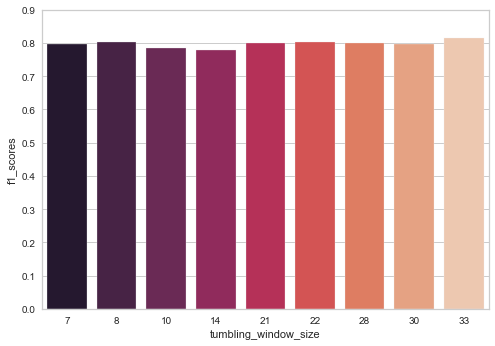

In [218]:
sns.barplot(x="tumbling_window_size", y="f1_scores", data=check_tumbling_window_size,
           palette="rocket")
plt.ylim(0, 0.9)

# E. Feature importance and selection

### 1. Data preparation for feature importance and selction

In [4]:
ws = 33
ows = 33
now = 609
    # for each holdout set, compute f1 score

test = get_dataset_value(now-ows, ws, ows)
train = get_dataset_value(now-2*ows, ws, ows)

         # output feature changes to binary, 1: non- churn, 0: churn
test[1][test[1]>0] = 1 # non-chrun
train[1][train[1]>0] = 1 # non-chrun
        
        # Balancing unbalanced output feature in train data set using SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(train[0], train[1])
        
X_train = pd.DataFrame(X_train,
                      columns=['total_values','total_quantity','avg_between',
                              'f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11'])
y_train = pd.DataFrame(y_train)
        
        # standardizing Temporal data in train set
train_X = pd.DataFrame()

for i in X_train.iloc[:,3:14].values:
        a = i - X_train.iloc[:,3:14].values.sum()
        b = a / np.std(X_train.iloc[:,3:14].values)
    
        new_row = pd.DataFrame( [[b]] )
        train_X = train_X.append(new_row, ignore_index = True)

train_X.columns = ['f']
train_X = pd.DataFrame(train_X.f.tolist(), 
                            columns=['f1','f2','f3','f4','f5','f6','f7','f8',
                                         'f9','f10','f11'])

        # standardizing traditional data in train set
        # Step 1: log1p
train_X2 = X_train.drop(columns=['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11'])
train_X2_log = np.log1p(train_X2)
        # Step 2: StandardScaler
scaler = StandardScaler()
train_X2_scaled = scaler.fit_transform(train_X2_log)

        # transform into a dataframe
train_X2_scaled = pd.DataFrame(train_X2_scaled, index=train_X2_log.index, 
                             columns=train_X2_log.columns)
final_train = pd.concat([train_X2_scaled, train_X], axis=1)
final_train = round(final_train,2)
        
        # # standardizing Temporal data in validation set
test_X = pd.DataFrame()

for i in test[0].iloc[:,3:14].values:
        a = i - test[0].iloc[:,3:14].values.sum()
        b = a / np.std(test[0].iloc[:,3:14].values)
    
        new_row = pd.DataFrame( [[b]] )
        test_X = test_X.append(new_row, ignore_index = True)

test_X.columns = ['f']
test_X = pd.DataFrame(test_X.f.tolist(), 
                            columns=['f1','f2','f3','f4','f5','f6','f7','f8',
                                         'f9','f10','f11'])

        # standardizing traditional data in validation set
        # Step 1: log1p
test_X2 = test[0].drop(columns=['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11'])
test_X2_log = np.log1p(test_X2)
        # Step 2: StandardScaler
scaler = StandardScaler()
test_X2_scaled = scaler.fit_transform(test_X2_log)

        # transform into a dataframe
test_X2_scaled = pd.DataFrame(test_X2_scaled, index=test_X2_log.index, 
                             columns=test_X2_log.columns)
        # Merge into final
final_test = pd.concat([test_X2_scaled, test_X], axis=1)
final_test = round(final_test,2)

### 2. Function of making table for feature imporance

In [5]:
def print_variable_importances( feature_names, dict_in, show_top = 14 ):
  if show_top is None:
    show_top = len(feature_names)
  
  to_print_titles = []
  to_print_scores = []
  
  for k, v in dict_in.items():
    feature_names_plus_scores = sorted( zip(v, feature_names) )
    feature_names_plus_scores.reverse()
    to_print_titles.append(k)
    to_print_scores.append(feature_names_plus_scores)

  line_parts = []
  for j in range(len(to_print_titles)):
    line_parts.append('{:<24}'.format(to_print_titles[j]))
  
  print('Rank | ' + ' | '.join( ['{:<24}'.format(x) for x in to_print_titles] ) )

  print('---- + ' + ' + '.join( [ '-'*24 ]*len(to_print_titles) ) )

  for i in range(show_top):
    line_parts = []
    for j in range(len(to_print_titles)):
      line_parts.append(  '{:<16}: {:.4f}'.format(to_print_scores[j][i][1], to_print_scores[j][i][0]) )
    print( '{:<4} | '.format(str(i)) + ' | '.join(line_parts) )

### 3. Function of printing accuracies and f1 score
##### (before and after of feature selection)

In [6]:
def feature_selection(deleted_train, deleted_test):
    print("'Original dataset'")
    xgb.fit(final_train, y_train) 
    print("train set accuracy : {:.3f}".format(xgb.score(final_train, y_train)))
    print("test set accuracy : {:.3f}".format(xgb.score(final_test, test[1])))
    y_pred = xgb.predict(final_test)
    f1 = f1_score(test[1], y_pred)
    print('Test set f1 score for best params:', round(f1,3))
    print('=========================================')
    print("'Deleted the least important feature'")
    xgb.fit(deleted_train, y_train) 
    print("train set accuracy : {:.3f}".format(xgb.score(deleted_train, y_train)))
    print("test set accuracy : {:.3f}".format(xgb.score(deleted_test, test[1])))
    y_pred = xgb.predict(deleted_test)
    f1 = f1_score(test[1], y_pred)
    print('Test set f1 score for best params:', round(f1,3))

### 4. Comparing result of different feature importance methods

###### 1) Univariate variable importance

In [150]:
us = GenericUnivariateSelect( score_func=mutual_info_classif, mode='k_best', param=14 )

us.fit(final_train,y_train)

feature_importance_scores = {}
feature_importance_scores['Filter'] = us.scores_

print_variable_importances( final_train.columns, feature_importance_scores, 14 )

Rank | Filter                  
---- + ------------------------
0    | avg_between     : 0.2902
1    | total_values    : 0.2485
2    | total_quantity  : 0.2298
3    | f2              : 0.1537
4    | f1              : 0.1379
5    | f6              : 0.1373
6    | f3              : 0.1373
7    | f4              : 0.1363
8    | f5              : 0.1237
9    | f8              : 0.1108
10   | f7              : 0.1103
11   | f11             : 0.0919
12   | f9              : 0.0863
13   | f10             : 0.0805


###### 2) XGBoost embeded feature importance

In [151]:
# final model of XGB
import xgboost as xgb
xgb = xgb.XGBClassifier(objective='binary:logistic',
                    silent=True, nthread=1, random_state=42, n_jobs=-1,
                    subsample= 0.20823379771832098, n_estimators= 862, 
                    min_child_weight= 8, max_depth= 5, 
                    learning_rate= 0.017194260557609198, gamma= 0.2976351441631313, 
                    colsample_bytree= 0.7824279936868144)
xgb.fit(final_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7824279936868144,
              gamma=0.2976351441631313, learning_rate=0.017194260557609198,
              max_delta_step=0, max_depth=5, min_child_weight=8, missing=None,
              n_estimators=862, n_jobs=-1, nthread=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
              subsample=0.20823379771832098, verbosity=1)

In [152]:
feature_importance_scores = {}
feature_importance_scores['Embeded XGB, gain'] = xgb.feature_importances_
print_variable_importances( final_train.columns, feature_importance_scores)

Rank | Embeded XGB, gain       
---- + ------------------------
0    | total_values    : 0.1181
1    | total_quantity  : 0.0920
2    | f3              : 0.0826
3    | f5              : 0.0770
4    | avg_between     : 0.0712
5    | f4              : 0.0704
6    | f2              : 0.0682
7    | f8              : 0.0658
8    | f6              : 0.0635
9    | f7              : 0.0615
10   | f11             : 0.0610
11   | f10             : 0.0581
12   | f1              : 0.0569
13   | f9              : 0.0538


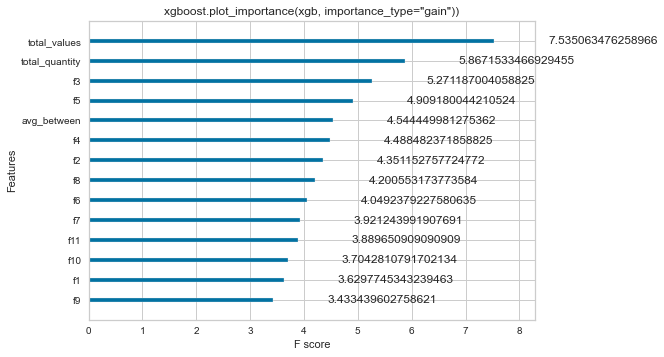

In [153]:
plot_importance(xgb, importance_type="gain")
plt.title('xgboost.plot_importance(xgb, importance_type="gain"))')
plt.show()

###### 3) Permutation Importance

In [154]:
xgb_perm = PermutationImportance(xgb, cv=3)
xgb_perm.fit(final_train.values, y_train.values)

feature_importance_scores['Perm cv XGB'] = xgb_perm.feature_importances_
print_variable_importances( final_train.columns, feature_importance_scores )

Rank | Embeded XGB, gain        | Perm cv XGB             
---- + ------------------------ + ------------------------
0    | total_values    : 0.1181 | total_values    : 0.0314
1    | total_quantity  : 0.0920 | avg_between     : 0.0290
2    | f3              : 0.0826 | total_quantity  : 0.0142
3    | f5              : 0.0770 | f3              : 0.0025
4    | avg_between     : 0.0712 | f10             : -0.0002
5    | f4              : 0.0704 | f5              : -0.0009
6    | f2              : 0.0682 | f6              : -0.0023
7    | f8              : 0.0658 | f4              : -0.0023
8    | f6              : 0.0635 | f9              : -0.0025
9    | f7              : 0.0615 | f1              : -0.0032
10   | f11             : 0.0610 | f8              : -0.0032
11   | f10             : 0.0581 | f11             : -0.0034
12   | f1              : 0.0569 | f2              : -0.0040
13   | f9              : 0.0538 | f7              : -0.0055


In [23]:
sum(xgb_perm.feature_importances_)

0.04284307815953391

###### 4) Recursive feature elimination (RFE)

In [155]:
rfe_xgb_embed = RFE(xgb, n_features_to_select = 14, step=1)
rfe_xgb_embed.fit(final_train, y_train)

RFE(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                            colsample_bylevel=1, colsample_bynode=1,
                            colsample_bytree=0.7824279936868144,
                            gamma=0.2976351441631313,
                            learning_rate=0.017194260557609198,
                            max_delta_step=0, max_depth=5, min_child_weight=8,
                            missing=None, n_estimators=862, n_jobs=-1,
                            nthread=1, objective='binary:logistic',
                            random_state=42, reg_alpha=0, reg_lambda=1,
                            scale_pos_weight=1, seed=None, silent=True,
                            subsample=0.20823379771832098, verbosity=1),
    n_features_to_select=14, step=1, verbose=0)

In [156]:
#print(rfe_xgb_embed.estimator_.feature_importances_)
rfe_xgb_embed_fi = np.asarray(rfe_xgb_embed.support_, dtype=np.float)
rfe_xgb_embed_fi[rfe_xgb_embed.support_] = rfe_xgb_embed.estimator_.feature_importances_
feature_importance_scores['RFE Embed XGB'] = rfe_xgb_embed_fi
print_variable_importances( final_train.columns, feature_importance_scores )

Rank | Embeded XGB, gain        | Perm cv XGB              | RFE Embed XGB           
---- + ------------------------ + ------------------------ + ------------------------
0    | total_values    : 0.1181 | total_values    : 0.0314 | total_values    : 0.1181
1    | total_quantity  : 0.0920 | avg_between     : 0.0290 | total_quantity  : 0.0920
2    | f3              : 0.0826 | total_quantity  : 0.0142 | f3              : 0.0826
3    | f5              : 0.0770 | f3              : 0.0025 | f5              : 0.0770
4    | avg_between     : 0.0712 | f10             : -0.0002 | avg_between     : 0.0712
5    | f4              : 0.0704 | f5              : -0.0009 | f4              : 0.0704
6    | f2              : 0.0682 | f6              : -0.0023 | f2              : 0.0682
7    | f8              : 0.0658 | f4              : -0.0023 | f8              : 0.0658
8    | f6              : 0.0635 | f9              : -0.0025 | f6              : 0.0635
9    | f7              : 0.0615 | f1             

###### 5) Visualization for RFE

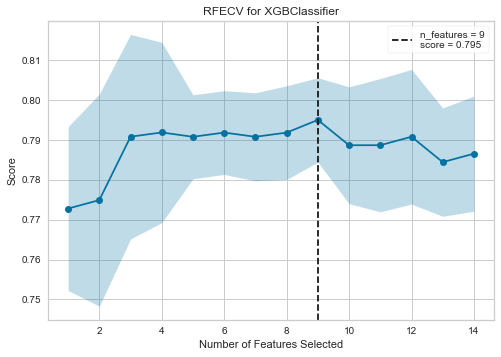

In [149]:
import xgboost as xgb
xgb = xgb.XGBClassifier(objective='binary:logistic',
                    silent=True, nthread=1, random_state=42, n_jobs=-1,
                    subsample= 0.20823379771832098, n_estimators= 862, 
                    min_child_weight= 8, max_depth= 5, 
                    learning_rate= 0.017194260557609198, gamma= 0.2976351441631313, 
                    colsample_bytree= 0.7824279936868144)
visualizer = RFECV(xgb)
visualizer.fit(final_train, y_train)        
visualizer.show() 

###### 6) Recursive feature elimination (RFE) with Permutation Importance

In [157]:
rfe_xgb_perm = RFE(PermutationImportance(xgb, cv=3), n_features_to_select = 9, step = 1)
rfe_xgb_perm.fit(final_train, y_train)

rfe_xgb_perm_fi = np.asarray(rfe_xgb_perm.support_, dtype=np.float)
rfe_xgb_perm_fi[rfe_xgb_perm.support_] = rfe_xgb_perm.estimator_.feature_importances_

feature_importance_scores['RFE Perm CV XGB'] = rfe_xgb_perm_fi
print_variable_importances( final_train.columns, feature_importance_scores )

Rank | Embeded XGB, gain        | Perm cv XGB              | RFE Embed XGB            | RFE Perm CV XGB         
---- + ------------------------ + ------------------------ + ------------------------ + ------------------------
0    | total_values    : 0.1181 | total_values    : 0.0314 | total_values    : 0.1181 | total_values    : 0.0357
1    | total_quantity  : 0.0920 | avg_between     : 0.0290 | total_quantity  : 0.0920 | avg_between     : 0.0338
2    | f3              : 0.0826 | total_quantity  : 0.0142 | f3              : 0.0826 | total_quantity  : 0.0095
3    | f5              : 0.0770 | f3              : 0.0025 | f5              : 0.0770 | f2              : 0.0013
4    | avg_between     : 0.0712 | f10             : -0.0002 | avg_between     : 0.0712 | f3              : 0.0004
5    | f4              : 0.0704 | f5              : -0.0009 | f4              : 0.0704 | f6              : 0.0004
6    | f2              : 0.0682 | f6              : -0.0023 | f2              : 0.0682 | f9   

In [158]:
# Deleting negative values from RFE Perm CV XGB feature importance
train_copy = final_train.copy()
test_copy = final_test.copy()
train_del = train_copy.drop(columns=['f8','f1','f5','f10','f11'])
test_del = test_copy.drop(columns=['f8','f1','f5','f10','f11'])
import xgboost as xgb
xgb = xgb.XGBClassifier(objective='binary:logistic',silent=True, nthread=1, random_state=42, n_jobs=-1,subsample= 0.20823379771832098, n_estimators= 862,  min_child_weight= 8, max_depth= 5, learning_rate= 0.017194260557609198, gamma= 0.2976351441631313, colsample_bytree= 0.7824279936868144)
feature_selection(train_del, test_del)

'Original dataset'
train set accuracy : 0.821
test set accuracy : 0.744
Test set f1 score for best params: 0.776
'Deleted the least important feature'
train set accuracy : 0.826
test set accuracy : 0.738
Test set f1 score for best params: 0.764


###### 7) Plot partial dependence of the two most important feature 'total valeus' and 'tavg between'

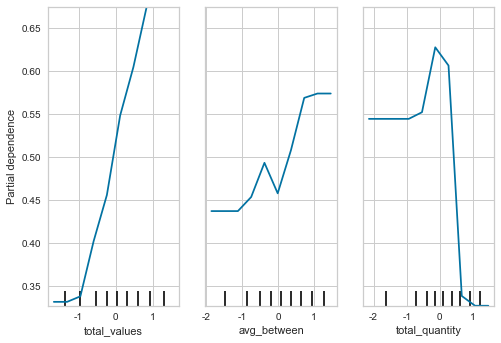

In [11]:
import xgboost as xgb
xgb = xgb.XGBClassifier(objective='binary:logistic',
                    silent=True, nthread=1, random_state=42, n_jobs=-1,
                    subsample= 0.20823379771832098, n_estimators= 862, 
                    min_child_weight= 8, max_depth= 5, 
                    learning_rate= 0.017194260557609198, gamma= 0.2976351441631313, 
                    colsample_bytree= 0.7824279936868144)
xgb.fit(final_train, y_train)

my_plots = plot_partial_dependence(xgb,       
                                   features=[0,1,2], 
                                   X=final_train,           
                                   feature_names=['total_values', 'avg_between',
                                                 'total_quantity'], # labels on graphs
                                   grid_resolution=10) 

# F. Final XGBoost model with the whole data set 

### 1. Prediction without holdout sets with deleted feature 'f6', 'f7', 'f11' in the whole data set

In [12]:
ws = 33
ows = 33
now = 609
    # for each holdout set, compute f1 score

test = get_dataset_value(now-ows, ws, ows)
train = get_dataset_value(now-2*ows, ws, ows)

         # output feature changes to binary, 1: non- churn, 0: churn
test[1][test[1]>0] = 1 # non-chrun
train[1][train[1]>0] = 1 # non-chrun
        
        # Balancing unbalanced output feature in train data set using SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(train[0], train[1])
        
X_train = pd.DataFrame(X_train,
                      columns=['total_values','total_quantity','avg_between',
                              'f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11'])
y_train = pd.DataFrame(y_train)
        
        # standardizing Temporal data in train set
train_X = pd.DataFrame()

for i in X_train.iloc[:,3:14].values:
        a = i - X_train.iloc[:,3:14].values.sum()
        b = a / np.std(X_train.iloc[:,3:14].values)
    
        new_row = pd.DataFrame( [[b]] )
        train_X = train_X.append(new_row, ignore_index = True)

train_X.columns = ['f']
train_X = pd.DataFrame(train_X.f.tolist(), 
                            columns=['f1','f2','f3','f4','f5','f6','f7','f8',
                                         'f9','f10','f11'])

        # standardizing traditional data in train set
        # Step 1: log1p
train_X2 = X_train.drop(columns=['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11'])
train_X2_log = np.log1p(train_X2)
        # Step 2: StandardScaler
scaler = StandardScaler()
train_X2_scaled = scaler.fit_transform(train_X2_log)

        # transform into a dataframe
train_X2_scaled = pd.DataFrame(train_X2_scaled, index=train_X2_log.index, 
                             columns=train_X2_log.columns)
final_train = pd.concat([train_X2_scaled, train_X], axis=1)
final_train = round(final_train,2)
        
        # # standardizing Temporal data in validation set
test_X = pd.DataFrame()

for i in test[0].iloc[:,3:14].values:
        a = i - test[0].iloc[:,3:14].values.sum()
        b = a / np.std(test[0].iloc[:,3:14].values)
    
        new_row = pd.DataFrame( [[b]] )
        test_X = test_X.append(new_row, ignore_index = True)

test_X.columns = ['f']
test_X = pd.DataFrame(test_X.f.tolist(), 
                            columns=['f1','f2','f3','f4','f5','f6','f7','f8',
                                         'f9','f10','f11'])

        # standardizing traditional data in validation set
        # Step 1: log1p
test_X2 = test[0].drop(columns=['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11'])
test_X2_log = np.log1p(test_X2)
        # Step 2: StandardScaler
scaler = StandardScaler()
test_X2_scaled = scaler.fit_transform(test_X2_log)

        # transform into a dataframe
test_X2_scaled = pd.DataFrame(test_X2_scaled, index=test_X2_log.index, 
                             columns=test_X2_log.columns)
        # Merge into final
final_test = pd.concat([test_X2_scaled, test_X], axis=1)
final_test = round(final_test,2)

In [13]:
y_test = test[1].copy()

In [159]:
# Deleting 
train = final_train.copy()
test = final_test.copy()
train = train.drop(columns=['f8','f1','f5','f10','f11'])
test = test.drop(columns=['f8','f1','f5','f10','f11'])
import xgboost as xgb
xgb = xgb.XGBClassifier(objective='binary:logistic',silent=True, nthread=1, random_state=42, n_jobs=-1,subsample= 0.20823379771832098, n_estimators= 862,  min_child_weight= 8, max_depth= 5, learning_rate= 0.017194260557609198, gamma= 0.2976351441631313, colsample_bytree= 0.7824279936868144)

xgb.fit(train, y_train) 
print("train set accuracy : {:.3f}".format(xgb.score(train, y_train)))
print("test set accuracy : {:.3f}".format(xgb.score(test, y_test)))
y_pred = xgb.predict(test)
f1 = f1_score(y_test, y_pred)
print('Test set f1 score for best params:', round(f1,3))

train set accuracy : 0.826
test set accuracy : 0.738
Test set f1 score for best params: 0.764


In [160]:
print('Confusion Matrix')
confusion = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=[1,0]),
                        index=['y_true Yes','y_ture No'],
                        columns=['y_predict Yes','y_predict No'])
print(confusion)

Confusion Matrix
            y_predict Yes  y_predict No
y_true Yes            373           131
y_ture No              99           275


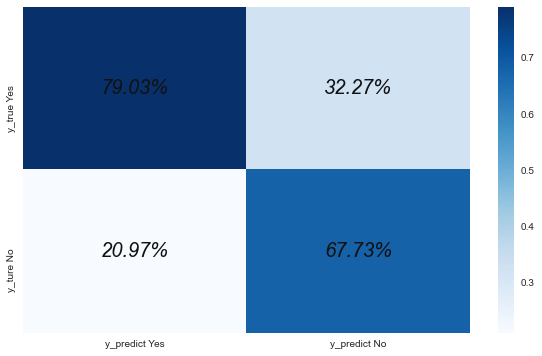

In [161]:
plt.figure(figsize=(10,6))
xticklables = ['y_predict Yes','y_predict No']
yticklables = ['y_true Yes','y_ture No']

annot_kws={'fontsize':20, 
           'fontstyle':'italic',  
           'color':"k",
           'alpha':1, 
           'verticalalignment':'center'}

sns.heatmap(confusion/np.sum(confusion), annot=True, 
            fmt='.2%', cmap='Blues',
           xticklabels = xticklables,
           yticklabels = yticklables,
           annot_kws = annot_kws)

# G. Pen Portraits of Churners vs Non-churners

### 1. Data preparation for pen portraits

In [163]:
ws = 33
ows = 33
now = 609
    # for each holdout set, compute f1 score

test = get_dataset_value(now-ows, ws, ows)
train = get_dataset_value(now-2*ows, ws, ows)

         # output feature changes to binary, 1: non- churn, 0: churn
test[1][test[1]>0] = 1 # non-chrun
train[1][train[1]>0] = 1 # non-chrun
        
        # Balancing unbalanced output feature in train data set using SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(train[0], train[1])
        
X_train = pd.DataFrame(X_train,
                      columns=['total_values','total_quantity','avg_between',
                              'f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11'])
y_train = pd.DataFrame(y_train)
        
        # standardizing Temporal data in train set
train_X = pd.DataFrame()

for i in X_train.iloc[:,3:14].values:
        a = i - X_train.iloc[:,3:14].values.sum()
        b = a / np.std(X_train.iloc[:,3:14].values)
    
        new_row = pd.DataFrame( [[b]] )
        train_X = train_X.append(new_row, ignore_index = True)

train_X.columns = ['f']
train_X = pd.DataFrame(train_X.f.tolist(), 
                            columns=['f1','f2','f3','f4','f5','f6','f7','f8',
                                         'f9','f10','f11'])

        # standardizing traditional data in train set
        # Step 1: log1p
train_X2 = X_train.drop(columns=['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11'])
train_X2_log = np.log1p(train_X2)
        # Step 2: StandardScaler
scaler = StandardScaler()
train_X2_scaled = scaler.fit_transform(train_X2_log)

        # transform into a dataframe
train_X2_scaled = pd.DataFrame(train_X2_scaled, index=train_X2_log.index, 
                             columns=train_X2_log.columns)
final_train = pd.concat([train_X2_scaled, train_X], axis=1)
final_train = round(final_train,2)
        
        # # standardizing Temporal data in validation set
test_X = pd.DataFrame()

for i in test[0].iloc[:,3:14].values:
        a = i - test[0].iloc[:,3:14].values.sum()
        b = a / np.std(test[0].iloc[:,3:14].values)
    
        new_row = pd.DataFrame( [[b]] )
        test_X = test_X.append(new_row, ignore_index = True)

test_X.columns = ['f']
test_X = pd.DataFrame(test_X.f.tolist(), 
                            columns=['f1','f2','f3','f4','f5','f6','f7','f8',
                                         'f9','f10','f11'])

        # standardizing traditional data in validation set
        # Step 1: log1p
test_X2 = test[0].drop(columns=['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11'])
test_X2_log = np.log1p(test_X2)
        # Step 2: StandardScaler
scaler = StandardScaler()
test_X2_scaled = scaler.fit_transform(test_X2_log)

        # transform into a dataframe
test_X2_scaled = pd.DataFrame(test_X2_scaled, index=test_X2_log.index, 
                             columns=test_X2_log.columns)
        # Merge into final
final_test = pd.concat([test_X2_scaled, test_X], axis=1)
final_test = round(final_test,2)

### 2. Prediction using optimized XGBoost classifier

In [164]:
import xgboost as xgb
xgb = xgb.XGBClassifier(objective='binary:logistic',
                    silent=True, nthread=1, random_state=42, n_jobs=-1,
                    subsample= 0.20823379771832098, n_estimators= 862, 
                    min_child_weight= 8, max_depth= 5, 
                    learning_rate= 0.017194260557609198, gamma= 0.2976351441631313, 
                    colsample_bytree= 0.7824279936868144)
# Deleting feature 'f8','f1','f5','f10','f11'
y_test = test[1].copy()
X_train = final_train.copy()
X_test = final_test.copy()
X_train = X_train.drop(columns=['f8','f1','f5','f10','f11'])
X_test = X_test.drop(columns=['f8','f1','f5','f10','f11'])

xgb.fit(X_train, y_train) 
y_pred = xgb.predict(X_test)

In [165]:
X_train.describe()

,total_values,total_quantity,avg_between,f2,f3,f4,f6,f7,f9
count,946.000000,946.000000,946.000000,946.000000,946.000000,946.000000,946.000000,946.000000,946.000000
mean,0.000042,0.000032,0.000148,-5159.114799,-5159.194905,-5159.100402,-5159.129397,-5159.165137,-5159.164218
std,1.000456,1.000544,1.000560,1.004182,0.887351,1.030459,1.066565,1.025529,1.011967
min,-2.520000,-2.240000,-2.140000,-5159.630000,-5159.630000,-5159.630000,-5159.630000,-5159.630000,-5159.630000
25%,-0.720000,-0.650000,-0.570000,-5159.630000,-5159.630000,-5159.630000,-5159.630000,-5159.630000,-5159.630000
50%,0.020000,0.080000,0.090000,-5159.550000,-5159.580000,-5159.540000,-5159.570000,-5159.630000,-5159.630000
75%,0.750000,0.780000,0.725000,-5159.020000,-5159.150000,-5159.060000,-5159.100000,-5159.160000,-5159.162500
max,2.490000,2.350000,2.070000,-5150.230000,-5151.720000,-5150.010000,-5146.260000,-5147.770000,-5149.120000


### 3. Finding churners and non-churners

###### 1) Table for churners and non-churners 

In [166]:
# Predicting churners using embeded probability in XGBoost
X_train['proba'] = xgb.predict_proba(X_train[X_train.columns])[:,1]

# Change label, 1 as non-chuners, 0 as churners
X_train.loc[ (X_train.proba >= 0.5), 'proba'] = 1  # not churn
X_train.loc[ (X_train.proba < 0.5), 'proba'] = 0  # churn

# Check the numbers of churners and non-churners
X_train['proba'].value_counts()

0.0    486
1.0    460
Name: proba, dtype: int64

In [167]:
result = X_train['proba'].value_counts()
t = Texttable()
t.add_rows( [ ['Customer','Number'], ['Churn', result[0]], ['Non-churn',result[1]]])
print(t.draw())

+-----------+--------+
| Customer  | Number |
+===========+========+
| Churn     | 486    |
+-----------+--------+
| Non-churn | 460    |
+-----------+--------+


In [169]:
data_proba = X_train.copy()
data_proba.head()

,total_values,total_quantity,avg_between,f2,f3,f4,f6,f7,f9,proba
0,-0.14,0.05,0.64,-5159.45,-5159.45,-5159.06,-5159.51,-5159.44,-5159.63,0.0
1,-1.13,-1.15,1.22,-5159.63,-5159.63,-5159.63,-5159.55,-5159.63,-5159.63,0.0
2,-1.78,-1.85,-2.14,-5159.63,-5159.63,-5159.63,-5159.63,-5159.63,-5159.63,0.0
3,-0.07,-0.21,0.60,-5159.63,-5159.63,-5159.26,-5159.51,-5159.53,-5159.23,0.0
4,-0.69,-0.25,0.94,-5159.63,-5159.63,-5159.63,-5159.63,-5159.45,-5159.63,0.0


In [170]:
# Adding number columns to match with original value
X_train = X_train.copy()
X_train.insert(loc=0, column='number', value=np.arange(len(X_train)))
X_train.head()

,number,total_values,total_quantity,avg_between,f2,f3,f4,f6,f7,f9,proba
0,0,-0.14,0.05,0.64,-5159.45,-5159.45,-5159.06,-5159.51,-5159.44,-5159.63,0.0
1,1,-1.13,-1.15,1.22,-5159.63,-5159.63,-5159.63,-5159.55,-5159.63,-5159.63,0.0
2,2,-1.78,-1.85,-2.14,-5159.63,-5159.63,-5159.63,-5159.63,-5159.63,-5159.63,0.0
3,3,-0.07,-0.21,0.60,-5159.63,-5159.63,-5159.26,-5159.51,-5159.53,-5159.23,0.0
4,4,-0.69,-0.25,0.94,-5159.63,-5159.63,-5159.63,-5159.63,-5159.45,-5159.63,0.0


In [171]:
# Making a new table of non-chuerns
non_churn = X_train['proba'] == 1
non_churn = X_train[non_churn]
# Making a new table of chuners
churn = X_train['proba'] == 0
churn = X_train[churn]

In [172]:
non_churn.head()

,number,total_values,total_quantity,avg_between,f2,f3,f4,f6,f7,f9,proba
5,5,1.06,1.22,-0.92,-5158.63,-5158.84,-5158.82,-5158.51,-5158.76,-5159.16,1.0
12,12,-0.49,-0.87,0.01,-5159.36,-5159.52,-5159.56,-5159.63,-5159.63,-5159.63,1.0
13,13,-0.41,-0.20,0.05,-5159.42,-5159.53,-5159.50,-5159.63,-5159.63,-5159.63,1.0
17,17,0.46,0.67,-0.26,-5159.41,-5159.31,-5159.42,-5159.29,-5159.45,-5158.86,1.0
23,23,1.70,1.70,-0.57,-5156.63,-5157.46,-5156.57,-5155.99,-5156.51,-5157.51,1.0


In [173]:
churn.head()

,number,total_values,total_quantity,avg_between,f2,f3,f4,f6,f7,f9,proba
0,0,-0.14,0.05,0.64,-5159.45,-5159.45,-5159.06,-5159.51,-5159.44,-5159.63,0.0
1,1,-1.13,-1.15,1.22,-5159.63,-5159.63,-5159.63,-5159.55,-5159.63,-5159.63,0.0
2,2,-1.78,-1.85,-2.14,-5159.63,-5159.63,-5159.63,-5159.63,-5159.63,-5159.63,0.0
3,3,-0.07,-0.21,0.60,-5159.63,-5159.63,-5159.26,-5159.51,-5159.53,-5159.23,0.0
4,4,-0.69,-0.25,0.94,-5159.63,-5159.63,-5159.63,-5159.63,-5159.45,-5159.63,0.0


###### 2) Importing a new dataset contains original value of each customers

In [174]:
train = get_dataset_value(now-2*ows, ws, ows)
train[1][train[1]>0] = 1 # non-chrun
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(train[0], train[1])
X_train.describe()

# Deleting feature 'f6','f7','f11'
X_train = X_train.drop(columns=['f6','f7','f11'])
X_train.head()

,total_values,total_quantity,avg_between,f1,f2,f3,f4,f5,f8,f9,f10
0,139.53,117,38,5.50,11.37,11.41,36.91,0.0,0.00,0.00,0.0
1,28.55,13,83,5.00,0.00,0.00,0.00,0.0,2.19,0.00,0.0
2,9.67,3,0,9.67,0.00,0.00,0.00,0.0,0.00,0.00,0.0
3,157.71,73,36,5.32,0.00,0.00,23.83,0.0,0.00,25.53,0.0
4,58.50,69,57,35.24,0.00,0.00,0.00,0.0,0.00,0.00,0.0


In [175]:
# Adding number columns to match with transformed churn and non-churn table
ori_train = X_train.copy()
ori_train.insert(loc=0, column='number', value=np.arange(len(ori_train)))
ori_train.head(3)

,number,total_values,total_quantity,avg_between,f1,f2,f3,f4,f5,f8,f9,f10
0,0,139.53,117,38,5.50,11.37,11.41,36.91,0.0,0.00,0.0,0.0
1,1,28.55,13,83,5.00,0.00,0.00,0.00,0.0,2.19,0.0,0.0
2,2,9.67,3,0,9.67,0.00,0.00,0.00,0.0,0.00,0.0,0.0


###### 3) Table for churners and non-churners with original values

In [176]:
non_churn_list = non_churn['number'].values.tolist()
churn_list = churn['number'].values.tolist()

churners = ori_train.loc[ori_train['number'].isin(churn_list)]
churners = churners.drop(columns=['number'])

non_churners = ori_train.loc[ori_train['number'].isin(non_churn_list)]
non_churners = non_churners.drop(columns=['number'])

In [177]:
round(churners.describe(),2)

,total_values,total_quantity,avg_between,f1,f2,f3,f4,f5,f8,f9,f10
count,486.00,486.00,486.00,486.00,486.00,486.00,486.00,486.00,486.00,486.00,486.00
mean,85.45,53.18,51.71,18.61,3.96,3.68,5.58,4.20,4.40,4.16,3.39
std,82.46,55.13,46.08,18.44,10.50,9.49,13.42,12.70,13.49,11.52,10.92
min,2.29,1.00,0.00,0.89,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,25.14,10.00,20.25,6.89,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,59.24,36.00,41.00,12.51,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,121.44,80.00,71.00,23.29,1.56,0.00,4.02,0.00,0.00,0.00,0.00
max,448.52,414.00,259.00,110.63,98.56,80.08,118.08,153.18,161.42,150.15,144.05


In [178]:
round(non_churners.describe(),2)

,total_values,total_quantity,avg_between,f1,f2,f3,f4,f5,f8,f9,f10
count,460.00,460.00,460.00,460.00,460.00,460.00,460.00,460.00,460.00,460.00,460.00
mean,951.53,700.33,12.10,68.86,63.90,53.60,64.09,61.82,60.26,57.15,51.99
std,1078.16,797.53,7.92,74.43,81.34,72.96,84.16,86.36,88.16,84.43,77.26
min,48.39,22.00,0.00,1.59,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,328.20,229.50,6.00,21.47,10.66,7.96,8.85,7.31,0.00,0.00,0.00
50%,599.29,451.50,11.00,43.62,35.91,29.42,35.45,37.76,29.55,28.53,24.92
75%,1196.39,884.25,16.25,91.74,85.10,66.36,85.93,82.10,84.50,78.08,71.98
max,8914.41,7076.00,66.00,493.45,604.46,508.77,618.39,722.03,960.65,675.94,707.69


### 4. Visualization of comparing churners and non-churners

###### 1) Box-plot of total values, total quantity and average between visits 

[(0.0, 150.0)]

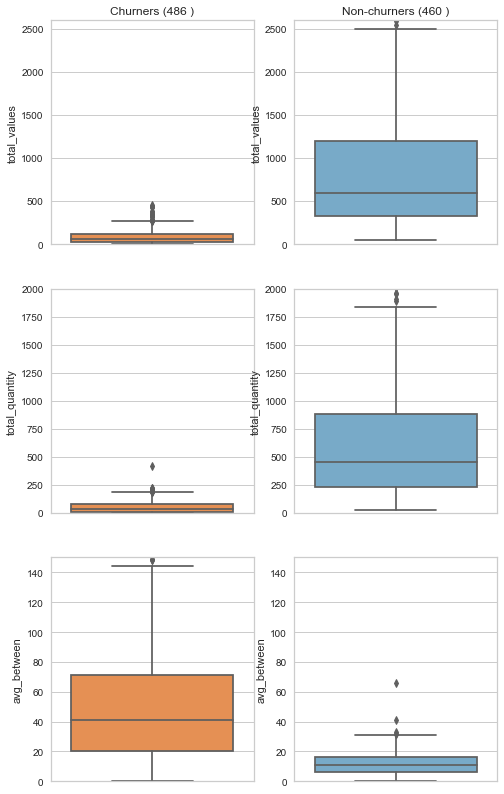

In [202]:
figure, (((ax1, ax2), (ax3, ax4), (ax5, ax6))) = plt.subplots(3, 2)
figure.set_size_inches(8,14)

sns.boxplot(churners.total_values, ax=ax1, orient = 'v', palette='Oranges'
           ).set_title('Churners (486 )')
sns.boxplot(non_churners.total_values, ax=ax2, orient = 'v', palette='Blues'
           ).set_title('Non-churners (460 )')
ax1.set(ylim=(0,2600))
ax2.set(ylim=(0,2600))

sns.boxplot(churners.total_quantity, ax=ax3, orient = 'v', palette='Oranges'
           )
sns.boxplot(non_churners.total_quantity, ax=ax4, orient = 'v', palette='Blues'
           )
ax3.set(ylim=(0,2000))
ax4.set(ylim=(0,2000))

sns.boxplot(churners.avg_between, ax=ax5, orient = 'v', palette='Oranges'
           )
sns.boxplot(non_churners.avg_between, ax=ax6, orient = 'v', palette='Blues'
           )
ax5.set(ylim=(0,150))
ax6.set(ylim=(0,150))

[(0.0, 2600.0)]

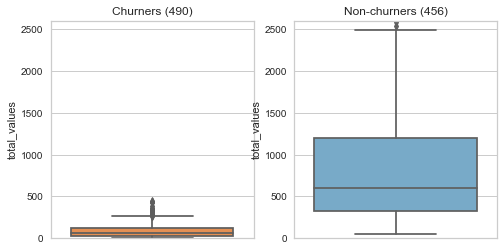

In [180]:
figure, (ax1, ax2) = plt.subplots(1, 2)
figure.set_size_inches(8,4)

sns.boxplot(churners.total_values, ax=ax1, orient = 'v', palette='Oranges'
           ).set_title('Churners (486 )')
sns.boxplot(non_churners.total_values, ax=ax2, orient = 'v', palette='Blues'
           ).set_title('Non-churners (460 )')
ax1.set(ylim=(0,2600))
ax2.set(ylim=(0,2600))

[(0.0, 2000.0)]

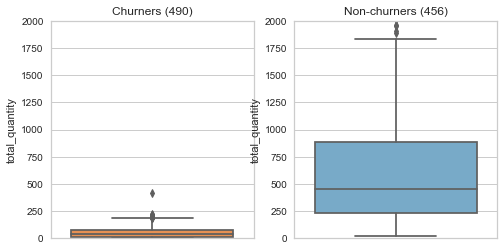

In [181]:
figure, (ax1, ax2) = plt.subplots(1, 2)
figure.set_size_inches(8,4)

sns.boxplot(churners.total_quantity, ax=ax1, orient = 'v', palette='Oranges'
           ).set_title('Churners (486 )')
sns.boxplot(non_churners.total_quantity, ax=ax2, orient = 'v', palette='Blues'
           ).set_title('Non-churners (460 )')
ax1.set(ylim=(0,2000))
ax2.set(ylim=(0,2000))

[(0.0, 150.0)]

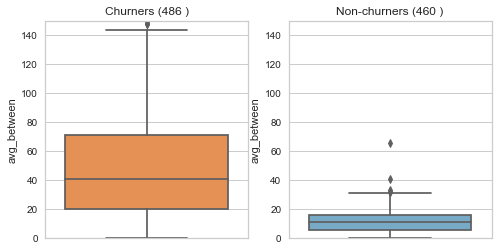

In [201]:
figure, (ax1, ax2) = plt.subplots(1, 2)
figure.set_size_inches(8,4)

sns.boxplot(churners.avg_between, ax=ax1, orient = 'v', palette='Oranges'
           ).set_title('Churners (486 )')
sns.boxplot(non_churners.avg_between, ax=ax2, orient = 'v', palette='Blues'
           ).set_title('Non-churners (460 )')
ax1.set(ylim=(0,150))
ax2.set(ylim=(0,150))

###### 2) Distribution of f5, f3 and f4, which shows the most importance features among other periods

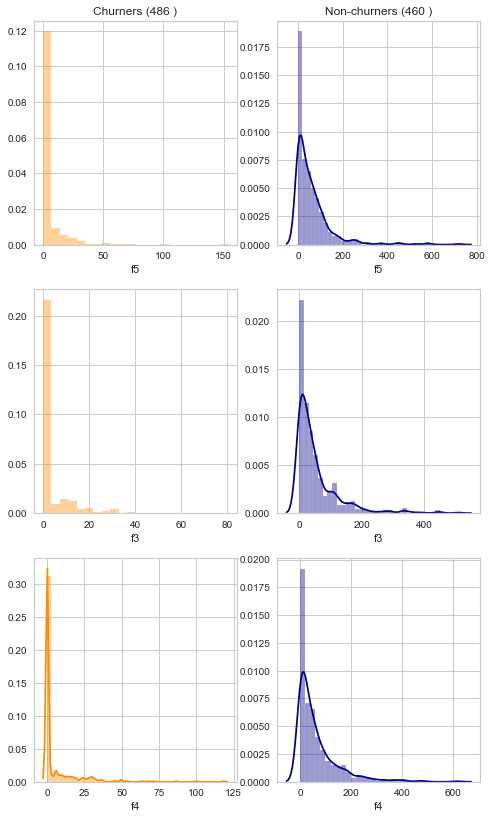

In [198]:
figure, axes  = plt.subplots(3, 2)
figure.set_size_inches(8,14)

sns.distplot(churners.f5, 
             ax=axes[0][0],color='darkorange').set_title('Churners (486 )')
sns.distplot(non_churners.f5, 
             ax=axes[0][1], color='darkblue').set_title('Non-churners (460 )')

sns.distplot(churners.f3,
             ax=axes[1][0],color='darkorange')
sns.distplot(non_churners.f3, 
             ax=axes[1][1],color='darkblue')

sns.distplot(churners.f4, 
             ax=axes[2][0],color='darkorange')
sns.distplot(non_churners.f4, 
             ax=axes[2][1],color='darkblue')

Text(0.5, 1.0, 'Non-churners (460 )')

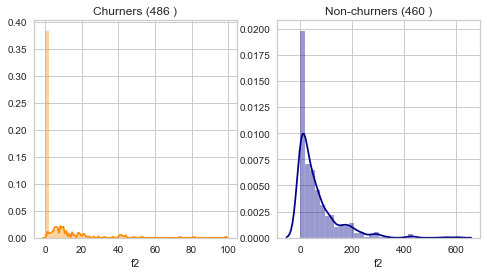

In [200]:
figure, (ax1, ax2)  = plt.subplots(1, 2)
figure.set_size_inches(8,4)

sns.distplot(churners.f2, 
             ax=ax1,color='darkorange').set_title('Churners (486 )')
sns.distplot(non_churners.f2, 
             ax=ax2, color='darkblue').set_title('Non-churners (460 )')

###### 3) Basic summary of churners and non-churners

In [185]:
def plot_sidebyside_bar( labels, series1, series2, xlabel_in = '', figwidth = 20 ):
  # The data
  indices = range(len(series1))
  names = labels
  # Calculate optimal width
  width = np.min(np.diff(indices))/3.

  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.bar(indices-width/2.,series1,width,color='b',label='-Ymin')
  ax.bar(indices+width/2.,series2,width,color='r',label='Ymax')
  #tiks = ax.get_xticks().tolist()
  plt.xticks(indices)
  ax.axes.set_xticklabels(names, rotation='vertical')
  ax.set_xlabel(xlabel_in)
  plt.gcf().set_figwidth(figwidth)
  plt.show()

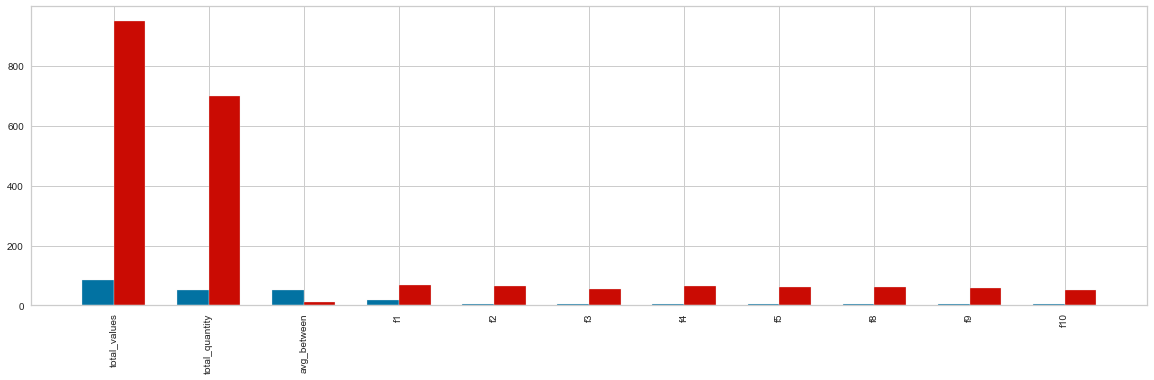

In [186]:
plot_sidebyside_bar( churners.mean().index, churners.mean().tolist(), 
                    non_churners.mean().tolist() )

###### 4) Using Boruta to investigate feature importance

In [187]:
from boruta import BorutaPy

In [188]:
data_proba.head()

,total_values,total_quantity,avg_between,f2,f3,f4,f6,f7,f9,proba
0,-0.14,0.05,0.64,-5159.45,-5159.45,-5159.06,-5159.51,-5159.44,-5159.63,0.0
1,-1.13,-1.15,1.22,-5159.63,-5159.63,-5159.63,-5159.55,-5159.63,-5159.63,0.0
2,-1.78,-1.85,-2.14,-5159.63,-5159.63,-5159.63,-5159.63,-5159.63,-5159.63,0.0
3,-0.07,-0.21,0.60,-5159.63,-5159.63,-5159.26,-5159.51,-5159.53,-5159.23,0.0
4,-0.69,-0.25,0.94,-5159.63,-5159.63,-5159.63,-5159.63,-5159.45,-5159.63,0.0


In [189]:
X = data_proba.drop(columns=['proba'])
y = data_proba.proba
rf = RandomForestClassifier(n_estimators = 10)
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)
feat_selector.fit(X.values, y)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	0
Iteration: 	10 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	0
Iteration: 	11 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	0
Iteration: 	12 / 100
Confirmed: 	9
Tentative: 	0
Rejected: 	0


BorutaPy finished running.

Iteration: 	13 / 100
Confirmed: 	9
Tentative: 	0
Rejected: 	0


BorutaPy(alpha=0.05,
         estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                          class_weight=None, criterion='gini',
                                          max_depth=None, max_features='auto',
                                          max_leaf_nodes=None, max_samples=None,
                                          min_impurity_decrease=0.0,
                                          min_impurity_split=None,
                                          min_samples_leaf=1,
                                          min_samples_split=2,
                                          min_weight_fraction_leaf=0.0,
                                          n_estimators=42, n_jobs=None,
                                          oob_score=False,
                                          random_state=RandomState(MT19937) at 0x26FCD839378,
                                          verbose=0, warm_start=False),
         max_iter=100, n_estimators='

In [190]:
print( X.columns[feat_selector.support_] )

Index(['total_values', 'total_quantity', 'avg_between', 'f2', 'f3', 'f4', 'f6',
       'f7', 'f9'],
      dtype='object')


###### 5) Partial Dependence Plots for two most importanct features, 'total_values' and 'avg_between'

In [191]:
from pdpbox import pdp, get_dataset, info_plots

In [192]:
import xgboost as xgb
xgb = xgb.XGBClassifier(objective='binary:logistic',
                    silent=True, nthread=1, random_state=42, n_jobs=-1,
                    subsample= 0.20823379771832098, n_estimators= 862, 
                    min_child_weight= 8, max_depth= 5, 
                    learning_rate= 0.017194260557609198, gamma= 0.2976351441631313, 
                    colsample_bytree= 0.7824279936868144)

In [193]:
xgb.fit(X,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7824279936868144,
              gamma=0.2976351441631313, learning_rate=0.017194260557609198,
              max_delta_step=0, max_depth=5, min_child_weight=8, missing=None,
              n_estimators=862, n_jobs=-1, nthread=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
              subsample=0.20823379771832098, verbosity=1)

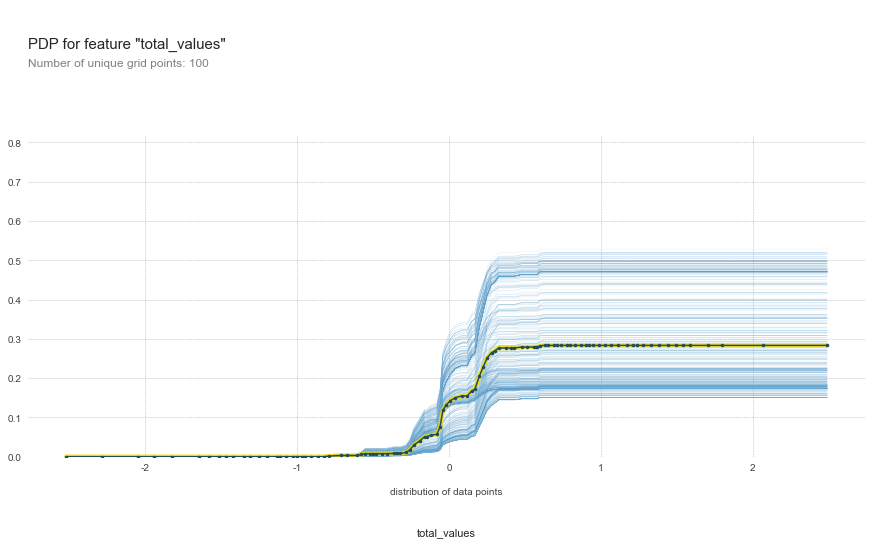

In [194]:
pdp_obj = pdp.pdp_isolate(
    model=xgb, dataset=data_proba, model_features=X.columns, feature='total_values',num_grid_points = 100
)

fig, axes = pdp.pdp_plot(pdp_obj, 'total_values', plot_lines=True, frac_to_plot=0.5, plot_pts_dist=True)

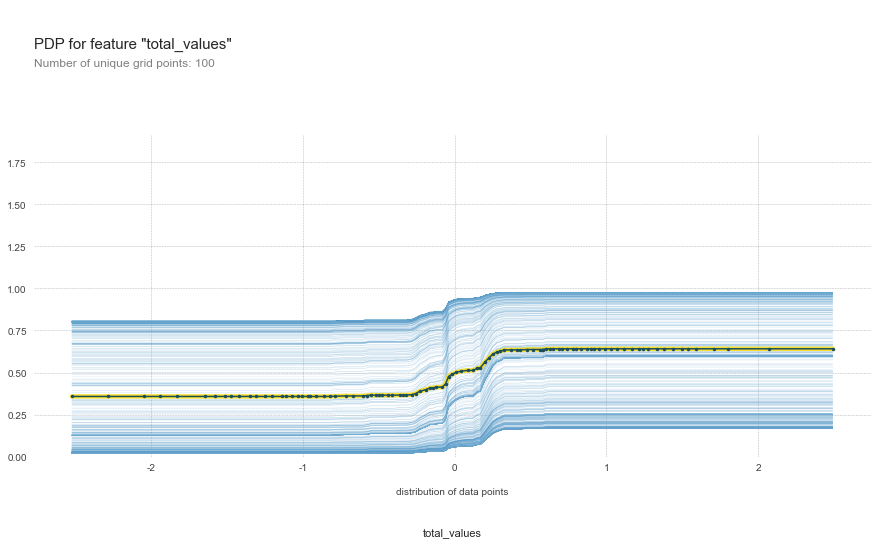

In [195]:
fig, axes = pdp.pdp_plot(pdp_obj, 'total_values', plot_lines=True, frac_to_plot=0.9, plot_pts_dist=True, center = False)

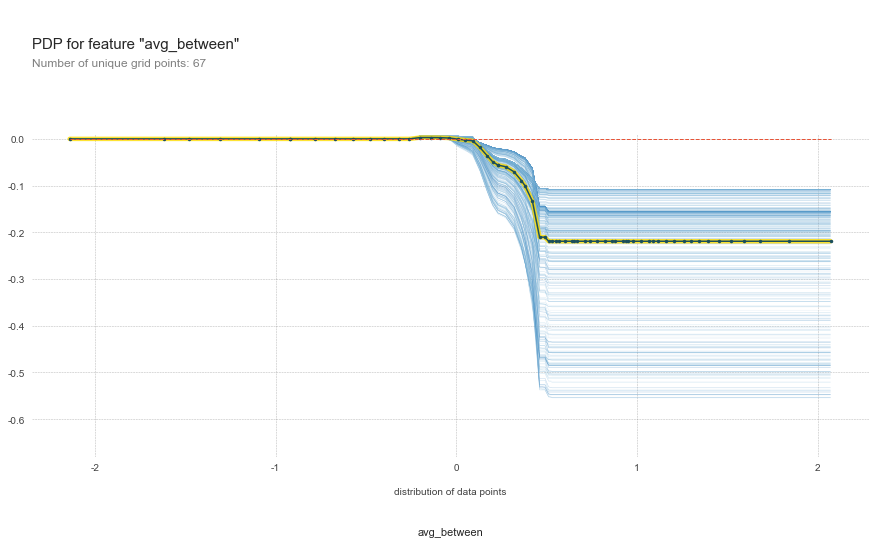

In [196]:
pdp_obj = pdp.pdp_isolate(
    model=xgb, dataset=data_proba, model_features=X.columns, feature='avg_between',num_grid_points = 100
)

fig, axes = pdp.pdp_plot(pdp_obj, 'avg_between', plot_lines=True, frac_to_plot=0.5, plot_pts_dist=True)

TypeError: clabel() got an unexpected keyword argument 'contour_label_fontsize'

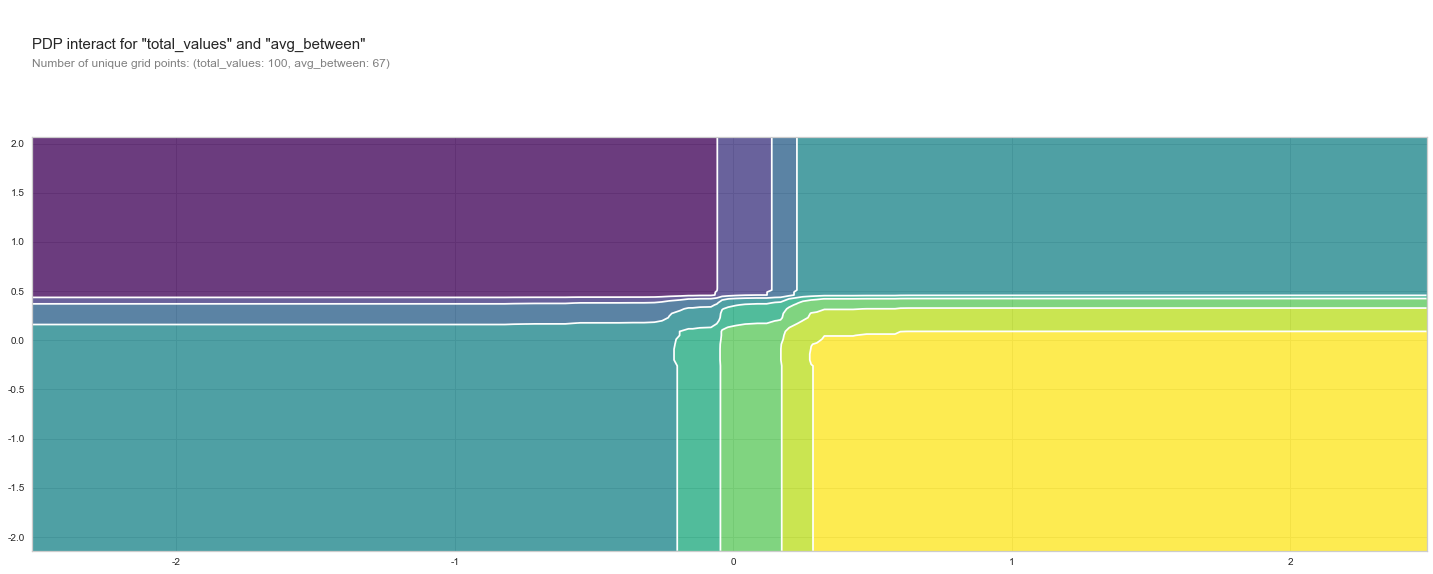

In [197]:
feats = ['total_values', 'avg_between']
p = pdp.pdp_interact(xgb, X, X.columns, feats,num_grid_points = [100,100])
pdp.pdp_interact_plot(p, feats, figsize = (25,10))

# H. Deployment

In [18]:
import xgboost as xgb
xgb = xgb.XGBClassifier(objective='binary:logistic',
                    silent=True, nthread=1, random_state=42, n_jobs=-1,
                    subsample= 0.20823379771832098, n_estimators= 862, 
                    min_child_weight= 8, max_depth= 5, 
                    learning_rate= 0.017194260557609198, gamma= 0.2976351441631313, 
                    colsample_bytree= 0.7824279936868144)

### 1. Model Implementation

#### Five steps of model implementation

##### 1) Load the new dataset

##### 2) Pre-processing the data

##### 3) Model prediction

##### 4) Model evaluation

##### 5) Checking churners and non-churners


###### 1) Load the new dataset

In [ ]:
ws = 33
ows = 33
now = 609

test = get_dataset_value(now-ows, ws, ows)
train = get_dataset_value(now-2*ows, ws, ows)

###### 2) Pre-processing the data 

In [ ]:
        # output feature changes to binary, 1: non- churn, 0: churn
test[1][test[1]>0] = 1 # non-chrun
train[1][train[1]>0] = 1 # non-chrun
        
        # Balancing unbalanced output feature in train data set using SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(train[0], train[1])
        
X_train = pd.DataFrame(X_train,
                      columns=['total_values','total_quantity','avg_between',
                              'f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11'])
y_train = pd.DataFrame(y_train)
        
        # standardizing Temporal data in train set
train_X = pd.DataFrame()

for i in X_train.iloc[:,3:14].values:
        a = i - X_train.iloc[:,3:14].values.sum()
        b = a / np.std(X_train.iloc[:,3:14].values)
    
        new_row = pd.DataFrame( [[b]] )
        train_X = train_X.append(new_row, ignore_index = True)

train_X.columns = ['f']
train_X = pd.DataFrame(train_X.f.tolist(), 
                            columns=['f1','f2','f3','f4','f5','f6','f7','f8',
                                         'f9','f10','f11'])

        # standardizing traditional data in train set
        # Step 1: log1p
train_X2 = X_train.drop(columns=['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11'])
train_X2_log = np.log1p(train_X2)
        # Step 2: StandardScaler
scaler = StandardScaler()
train_X2_scaled = scaler.fit_transform(train_X2_log)

        # transform into a dataframe
train_X2_scaled = pd.DataFrame(train_X2_scaled, index=train_X2_log.index, 
                             columns=train_X2_log.columns)
final_train = pd.concat([train_X2_scaled, train_X], axis=1)
final_train = round(final_train,2)
        
        # # standardizing Temporal data in validation set
test_X = pd.DataFrame()

for i in test[0].iloc[:,3:14].values:
        a = i - test[0].iloc[:,3:14].values.sum()
        b = a / np.std(test[0].iloc[:,3:14].values)
    
        new_row = pd.DataFrame( [[b]] )
        test_X = test_X.append(new_row, ignore_index = True)

test_X.columns = ['f']
test_X = pd.DataFrame(test_X.f.tolist(), 
                            columns=['f1','f2','f3','f4','f5','f6','f7','f8',
                                         'f9','f10','f11'])

        # standardizing traditional data in validation set
        # Step 1: log1p
test_X2 = test[0].drop(columns=['f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11'])
test_X2_log = np.log1p(test_X2)
        # Step 2: StandardScaler
scaler = StandardScaler()
test_X2_scaled = scaler.fit_transform(test_X2_log)

        # transform into a dataframe
test_X2_scaled = pd.DataFrame(test_X2_scaled, index=test_X2_log.index, 
                             columns=test_X2_log.columns)
        # Merge into final
final_test = pd.concat([test_X2_scaled, test_X], axis=1)
final_test = round(final_test,2)

        # Deleting feature 'f1'
y_test = test[1].copy()
X_train = final_train.copy()
X_test = final_test.copy()
X_train = X_train.drop(columns=['f8','f1','f5','f10','f11'])
X_test = X_test.drop(columns=['f8','f1','f5','f10','f11'])

###### 3) Model prediction

In [ ]:
import xgboost as xgb
xgb = xgb.XGBClassifier(objective='binary:logistic',
                    silent=True, nthread=1, random_state=42, n_jobs=-1,
                    subsample= 0.20823379771832098, n_estimators= 862, 
                    min_child_weight= 8, max_depth= 5, 
                    learning_rate= 0.017194260557609198, gamma= 0.2976351441631313, 
                    colsample_bytree= 0.7824279936868144)

xgb.fit(X_train, y_train) 
y_pred = xgb.predict(X_test)

###### 4) Model evaluation

In [ ]:
xgb.fit(train, y_train) 
print("train set accuracy : {:.3f}".format(xgb.score(X_train, y_train)))
print("test set accuracy : {:.3f}".format(xgb.score(X_test, y_test)))
f1 = f1_score(y_test, y_pred)
print('Test set f1 score for best params:', round(f1,3))
print('=========================================')
print('Confusion Matrix')
confusion = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=[1,0]),
                        index=['y_true Yes','y_ture No'],
                        columns=['y_predict Yes','y_predict No'])
print(confusion)

plt.figure(figsize=(10,6))
xticklables = ['y_predict Yes','y_predict No']
yticklables = ['y_true Yes','y_ture No']

annot_kws={'fontsize':20, 
           'fontstyle':'italic',  
           'color':"k",
           'alpha':1, 
           'verticalalignment':'center'}

sns.heatmap(confusion/np.sum(confusion), annot=True, 
            fmt='.2%', cmap='Blues',
           xticklabels = xticklables,
           yticklabels = yticklables,
           annot_kws = annot_kws)

###### 5) Checking churners and non-churners

In [ ]:
# Predicting churners using embeded probability in XGBoost
X_train['proba'] = xgb.predict_proba(X_train[X_train.columns])[:,1]

# Change label, 1 as non-chuners, 0 as churners
X_train.loc[ (X_train.proba >= 0.5), 'proba'] = 1  # not churn
X_train.loc[ (X_train.proba < 0.5), 'proba'] = 0  # churn

# Checking the number of customer who churned and not churned
t = Texttable()
t.add_rows( [ ['Customer','Number'], ['Churn', result[0]], ['Non-churn',result[1]]])
print(t.draw())